# Data loading

In [1]:
import itertools
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

from ev_simulation_model.data import load_norway_residential_data
from ev_simulation_model.io import ConditionalMvnMixtureExporter
from ev_simulation_model.models import ConditionalMvnMixture, MultivariateNormal

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
CWD = Path("/Users/phipag/Git/powertac/ev-simulation-model")

In [3]:
raw_df = load_norway_residential_data(CWD / "data" / "norway_residential" / "Dataset 1_EV charging reports.csv")

# Density estimation

## Exploring the densities

In [4]:
density_df = raw_df[["Duration_hours", "El_kWh", "Start_plugin_hour"]]
density_df

Duration_hours  El_kWh  Start_plugin_hour
0           0.050000    0.30                 10
1           0.136667    0.87                 10
2           8.216389   29.87                 11
3          24.419722   15.56                 16
4           0.970556    3.62                 22
...              ...     ...                ...
6873        4.530000   13.43                 17
6874        3.182222    9.10                 18
6875        1.203889    4.28                 19
6876        0.352500    2.31                 19
6877        3.184167   20.14                 20

[6878 rows x 3 columns]

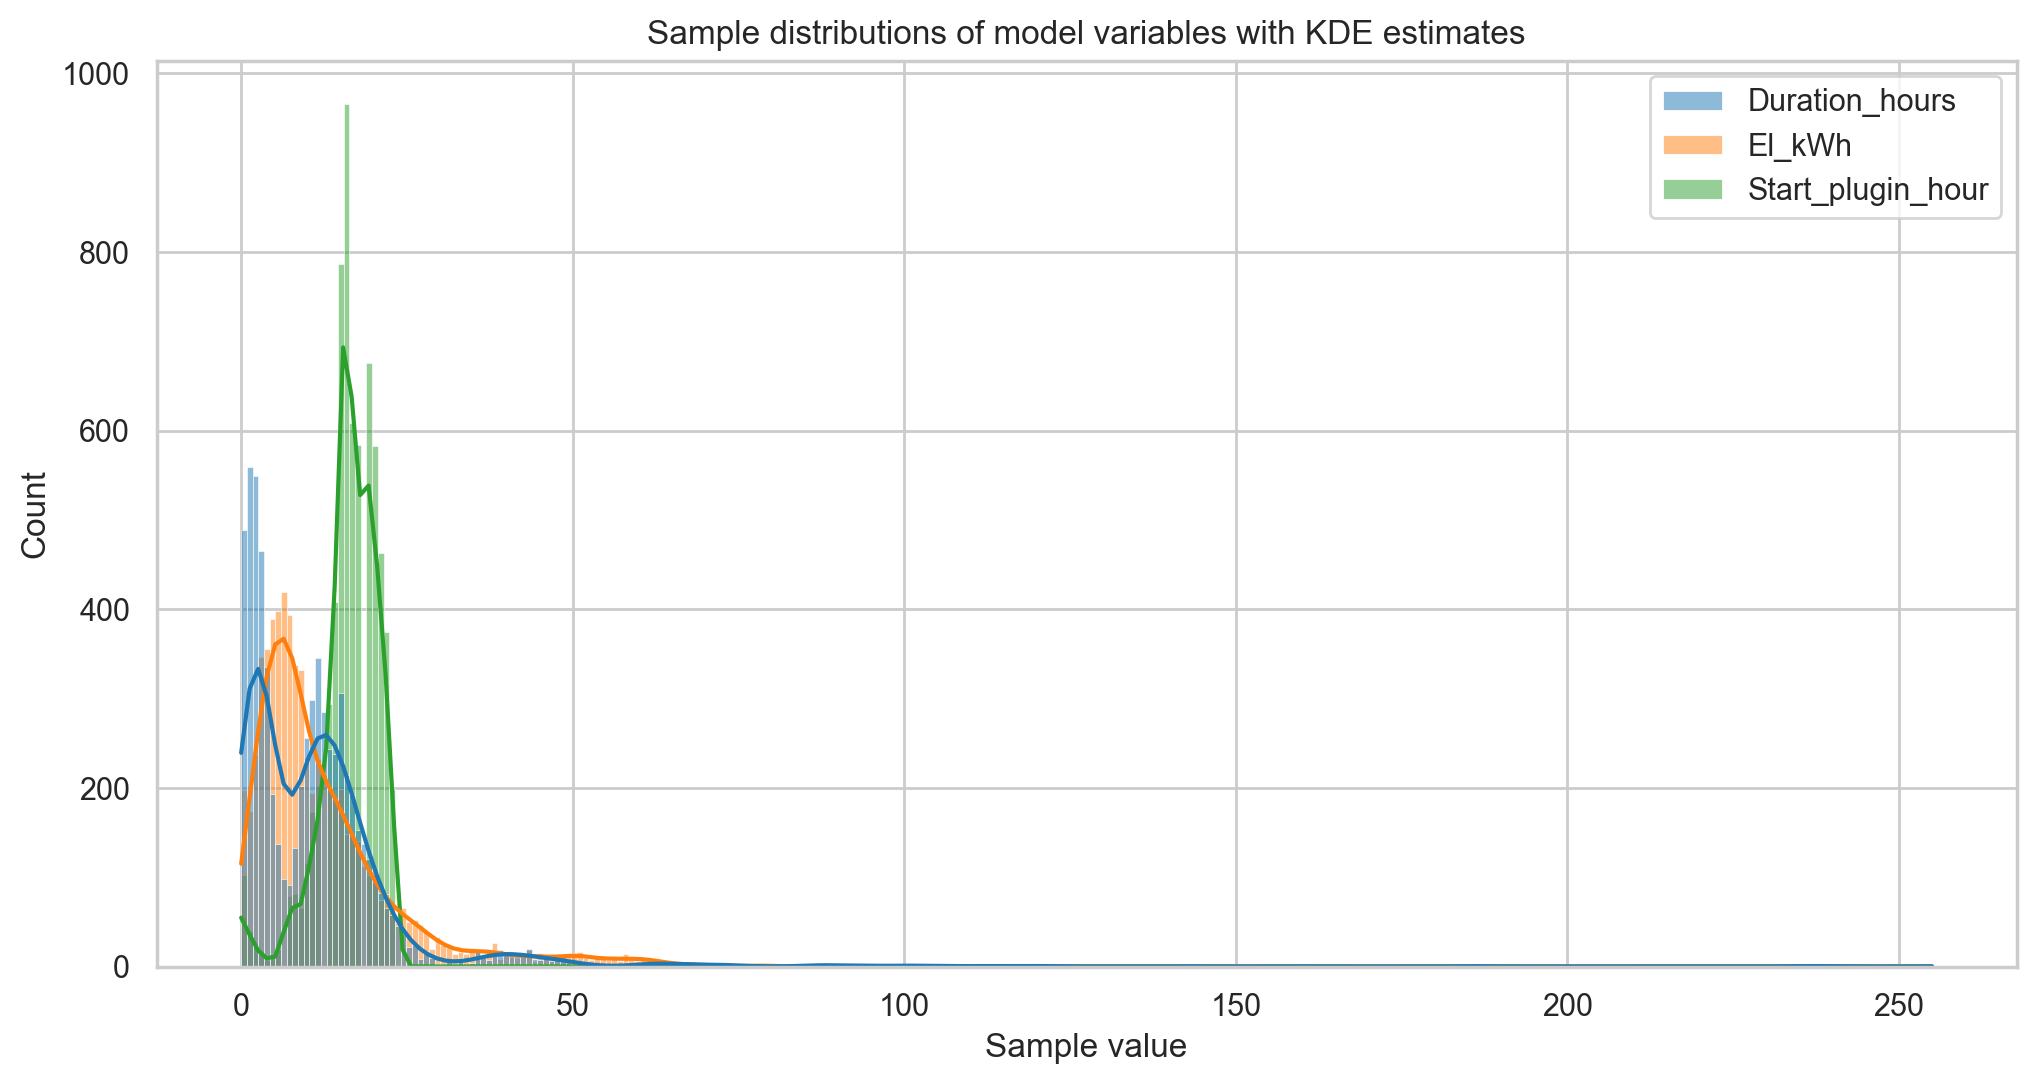

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(density_df, kde=True, ax=ax)
ax.set_title("Sample distributions of model variables with KDE estimates")
ax.set_xlabel("Sample value");

Let's remove the outliers in `Duration_hours` and `El_kWh` first by filtering out datapoints with a `zscore < 3`. This will also filter out `NaN` values.

In [6]:
density_df = density_df[
    (density_df["Duration_hours"] - density_df["Duration_hours"].mean()) / density_df["Duration_hours"].std(ddof=0) < 3
].copy()
density_df = density_df[
    (density_df["El_kWh"] - density_df["El_kWh"].mean()) / density_df["El_kWh"].std(ddof=0) < 3
].copy()
density_df

Duration_hours  El_kWh  Start_plugin_hour
0           0.050000    0.30                 10
1           0.136667    0.87                 10
2           8.216389   29.87                 11
3          24.419722   15.56                 16
4           0.970556    3.62                 22
...              ...     ...                ...
6873        4.530000   13.43                 17
6874        3.182222    9.10                 18
6875        1.203889    4.28                 19
6876        0.352500    2.31                 19
6877        3.184167   20.14                 20

[6544 rows x 3 columns]

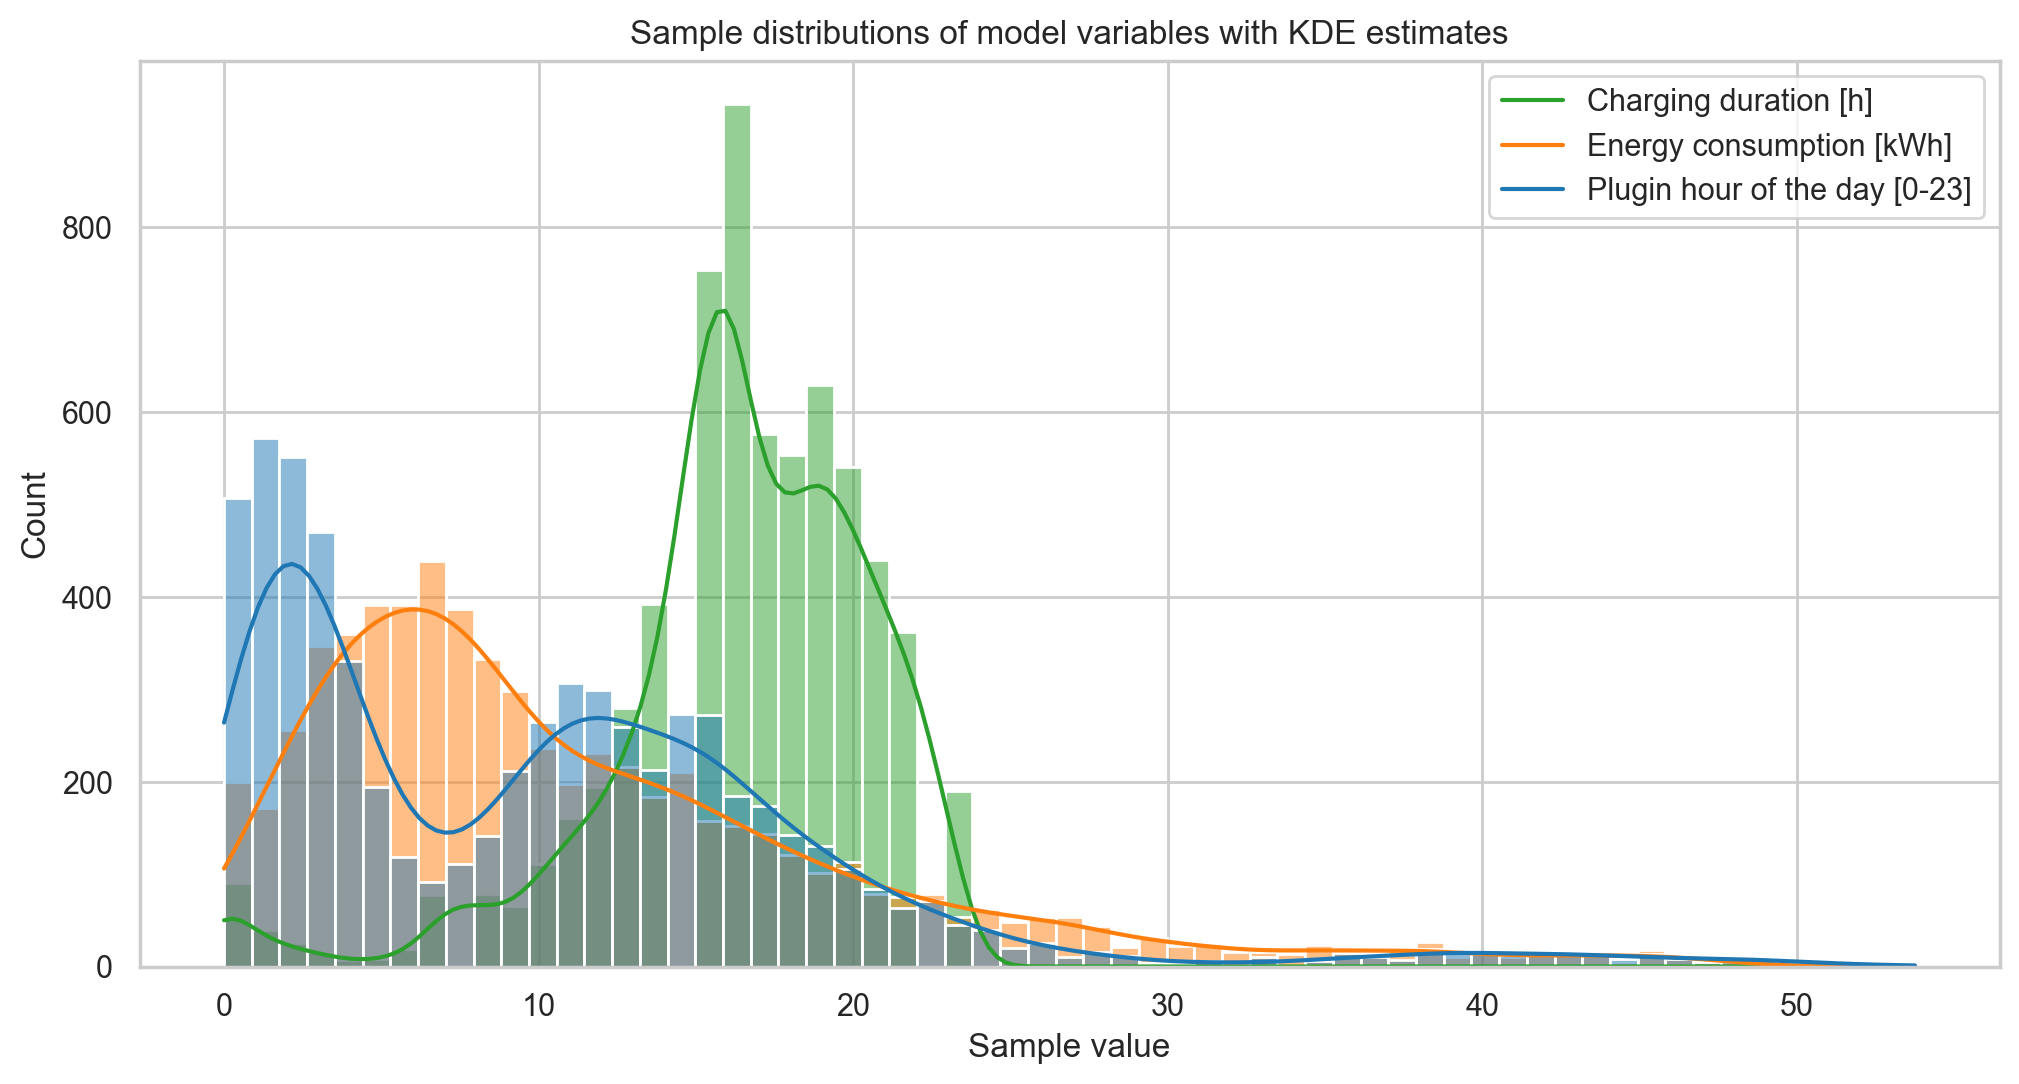

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(density_df, kde=True, ax=ax)
ax.set_title("Sample distributions of model variables with KDE estimates")
ax.legend(labels=["Charging duration [h]", "Energy consumption [kWh]", "Plugin hour of the day [0-23]"])
ax.set_xlabel("Sample value")
fig.savefig("figures/sample_distributions.pdf");

In [8]:
density_df.describe()

Duration_hours       El_kWh  Start_plugin_hour
count     6544.000000  6544.000000        6544.000000
mean        10.222456    11.363588          16.317848
std          9.062916     8.894950           4.345939
min          0.003333     0.010000           0.000000
25%          2.655625     5.100000          15.000000
50%          9.581806     8.800000          17.000000
75%         14.958056    15.290000          19.000000
max         53.754722    48.120000          23.000000

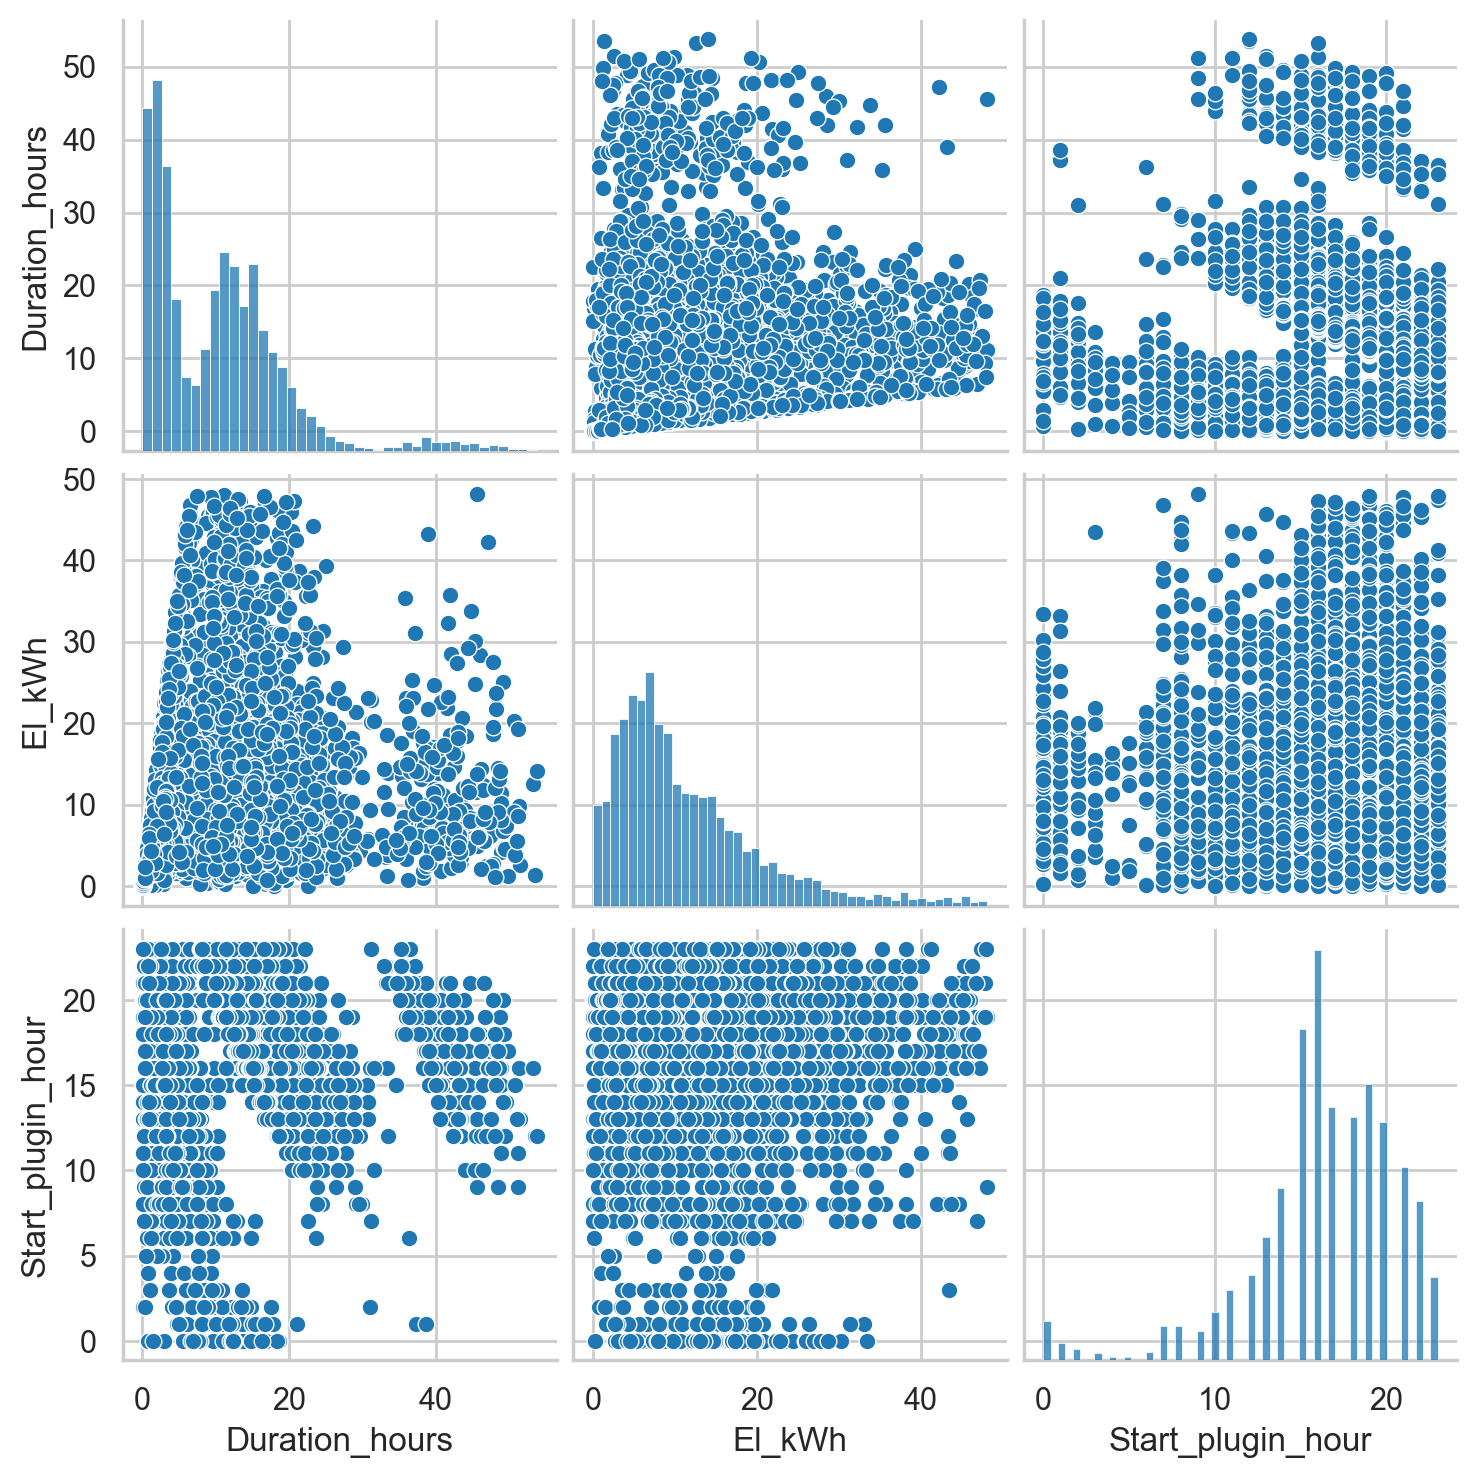

In [9]:
sns.pairplot(data=density_df, diag_kind="hist");

## Estimating the densities with a Gaussian Mixture Model

In [10]:
density_gmm_df = density_df.copy()

In [11]:
lowest_bic = np.infty
bics = np.array([], dtype=np.float_)
n_components_range = range(1, 20)
cov_types = ["spherical", "tied", "diag", "full"]
for cov_type in cov_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type)
        gmm.fit(density_gmm_df)
        bics = np.append(bics, gmm.bic(density_gmm_df))
        if bics[-1] < lowest_bic:
            lowest_bic = bics[-1]
# Deleting last gmm variable to avoid confusion
del gmm

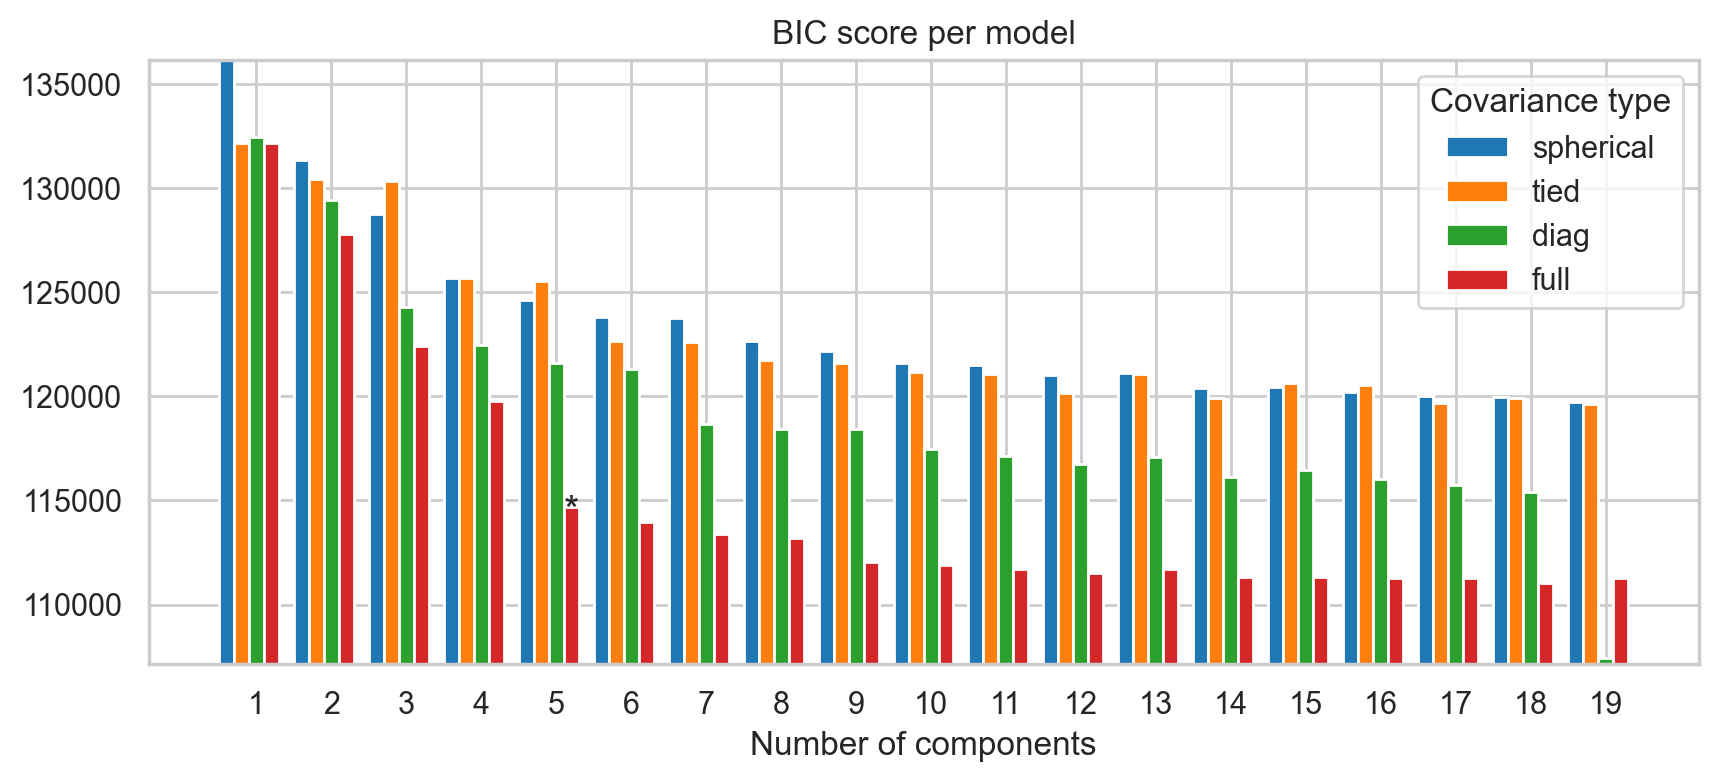

In [12]:
color_iter = itertools.cycle(sns.color_palette(as_cmap=True))
bars = []

fig = plt.figure(figsize=(10, 4))
spl = plt.subplot(1, 1, 1)
for i, (cov_type, color) in enumerate(zip(cov_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bics[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bics.min() * 1.01 - 0.01 * bics.max(), bics.max()])
plt.title("BIC score per model")
# xpos = np.mod(bics.argmin(), len(n_components_range)) + 0.65 + 0.2 * np.floor(bics.argmin() / len(n_components_range))
xpos = 5  # We manually select 5 components as the best model
# plt.text(xpos, bics.min() * 0.97 + 0.03 * bics.max(), "*", fontsize=14)
plt.text(xpos + 0.1, bics[5] * 0.92 + 0.03, "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cov_types, title="Covariance type")
fig.savefig("figures/gmm_bic_scores.pdf");

In [13]:
# We do not need a random_state because we check the model robustness below through repeated sampling
best_gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=None)
density_gmm_df["cluster"] = best_gmm.fit_predict(density_df)

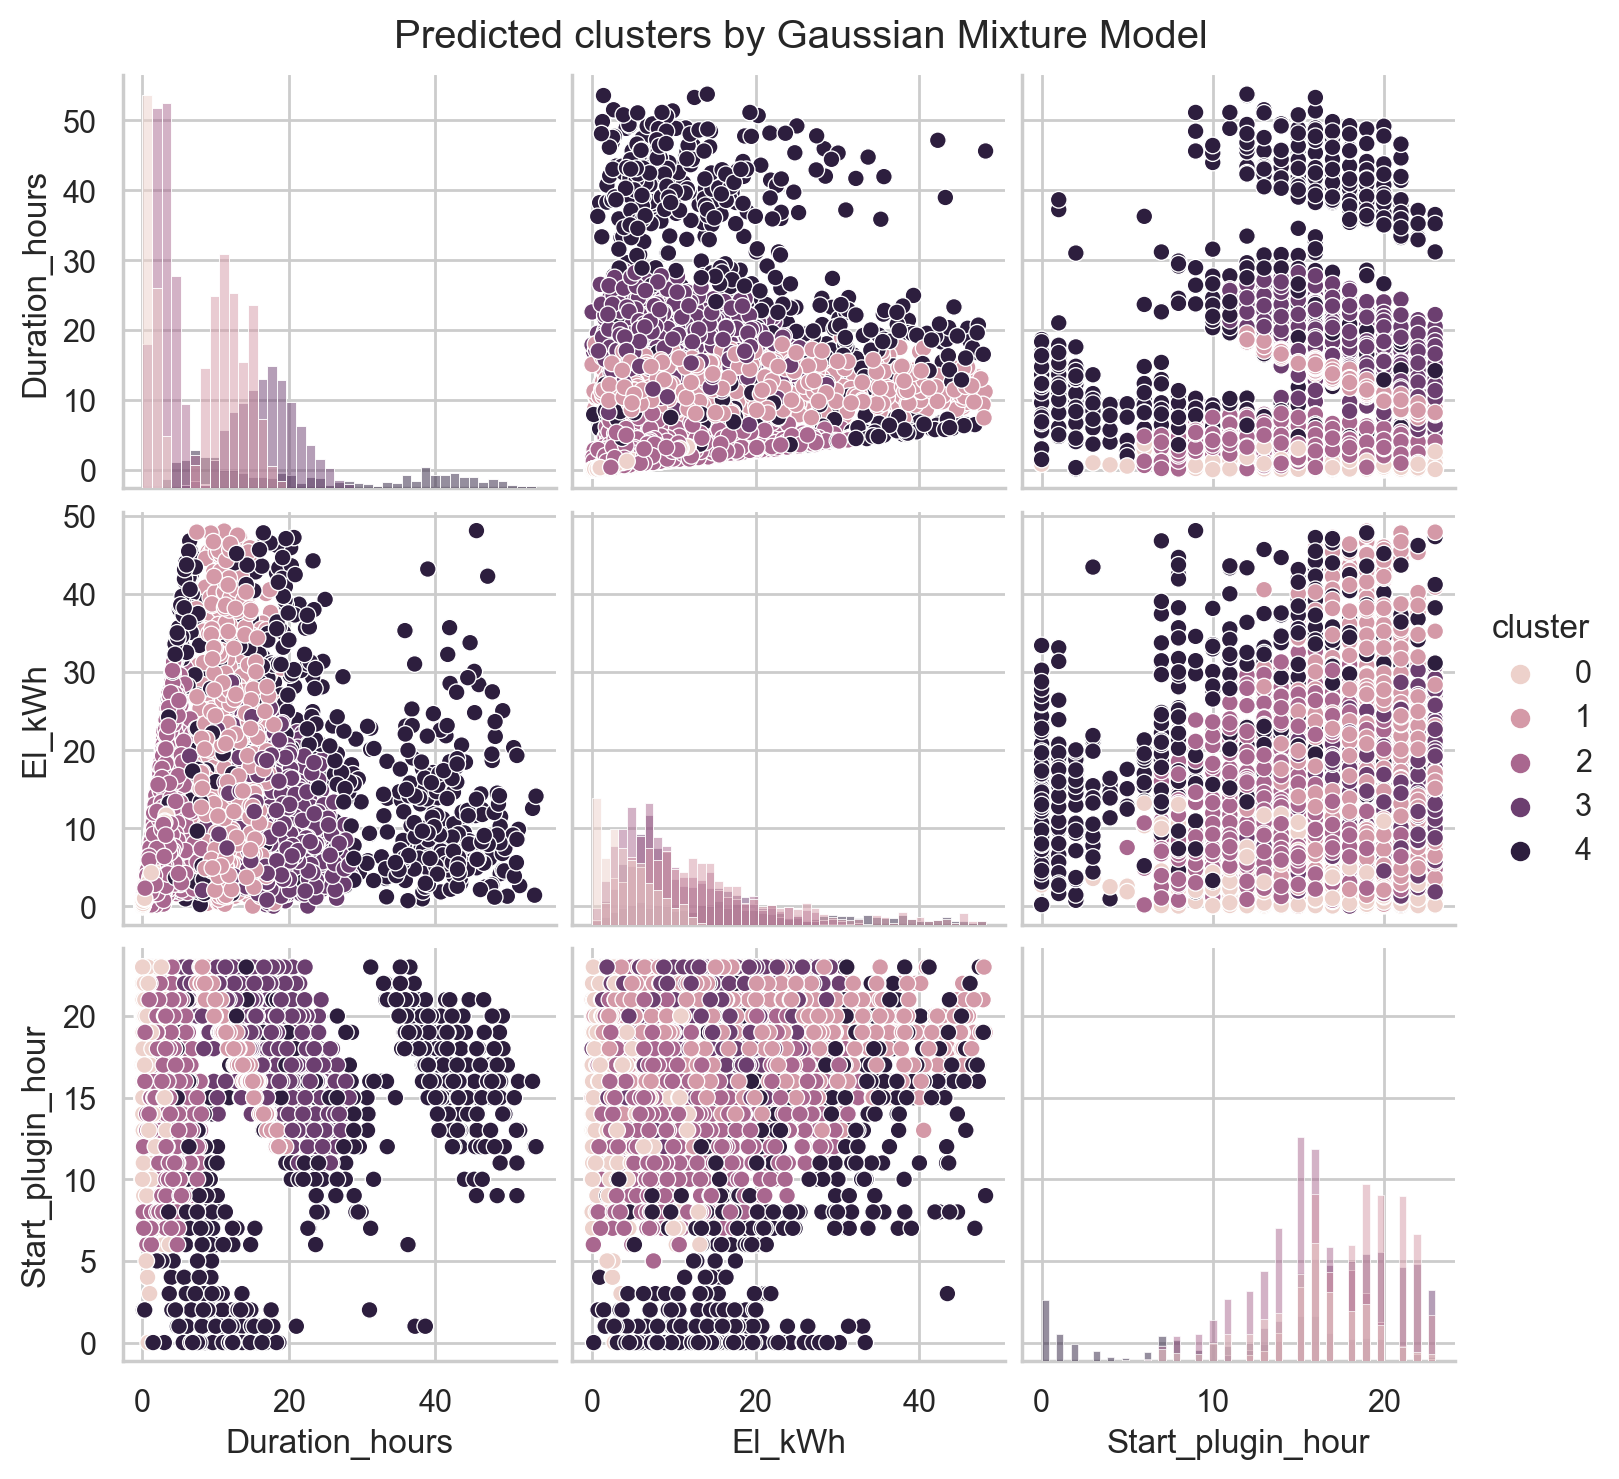

In [14]:
grid = sns.pairplot(data=density_gmm_df, hue="cluster", diag_kind="hist")
grid.figure.suptitle("Predicted clusters by Gaussian Mixture Model")
grid.tight_layout();

## Generating data from the fitted mixture distributions
This is the joint mixture distribution $p(\text{Duration_hours}, \text{El_kWh}, \text{Start_plugin_hour})$

In [15]:
samples, clusters = best_gmm.sample(len(density_df))
density_generated_df = pd.DataFrame(samples, columns=density_df.columns)
density_generated_df["cluster"] = clusters

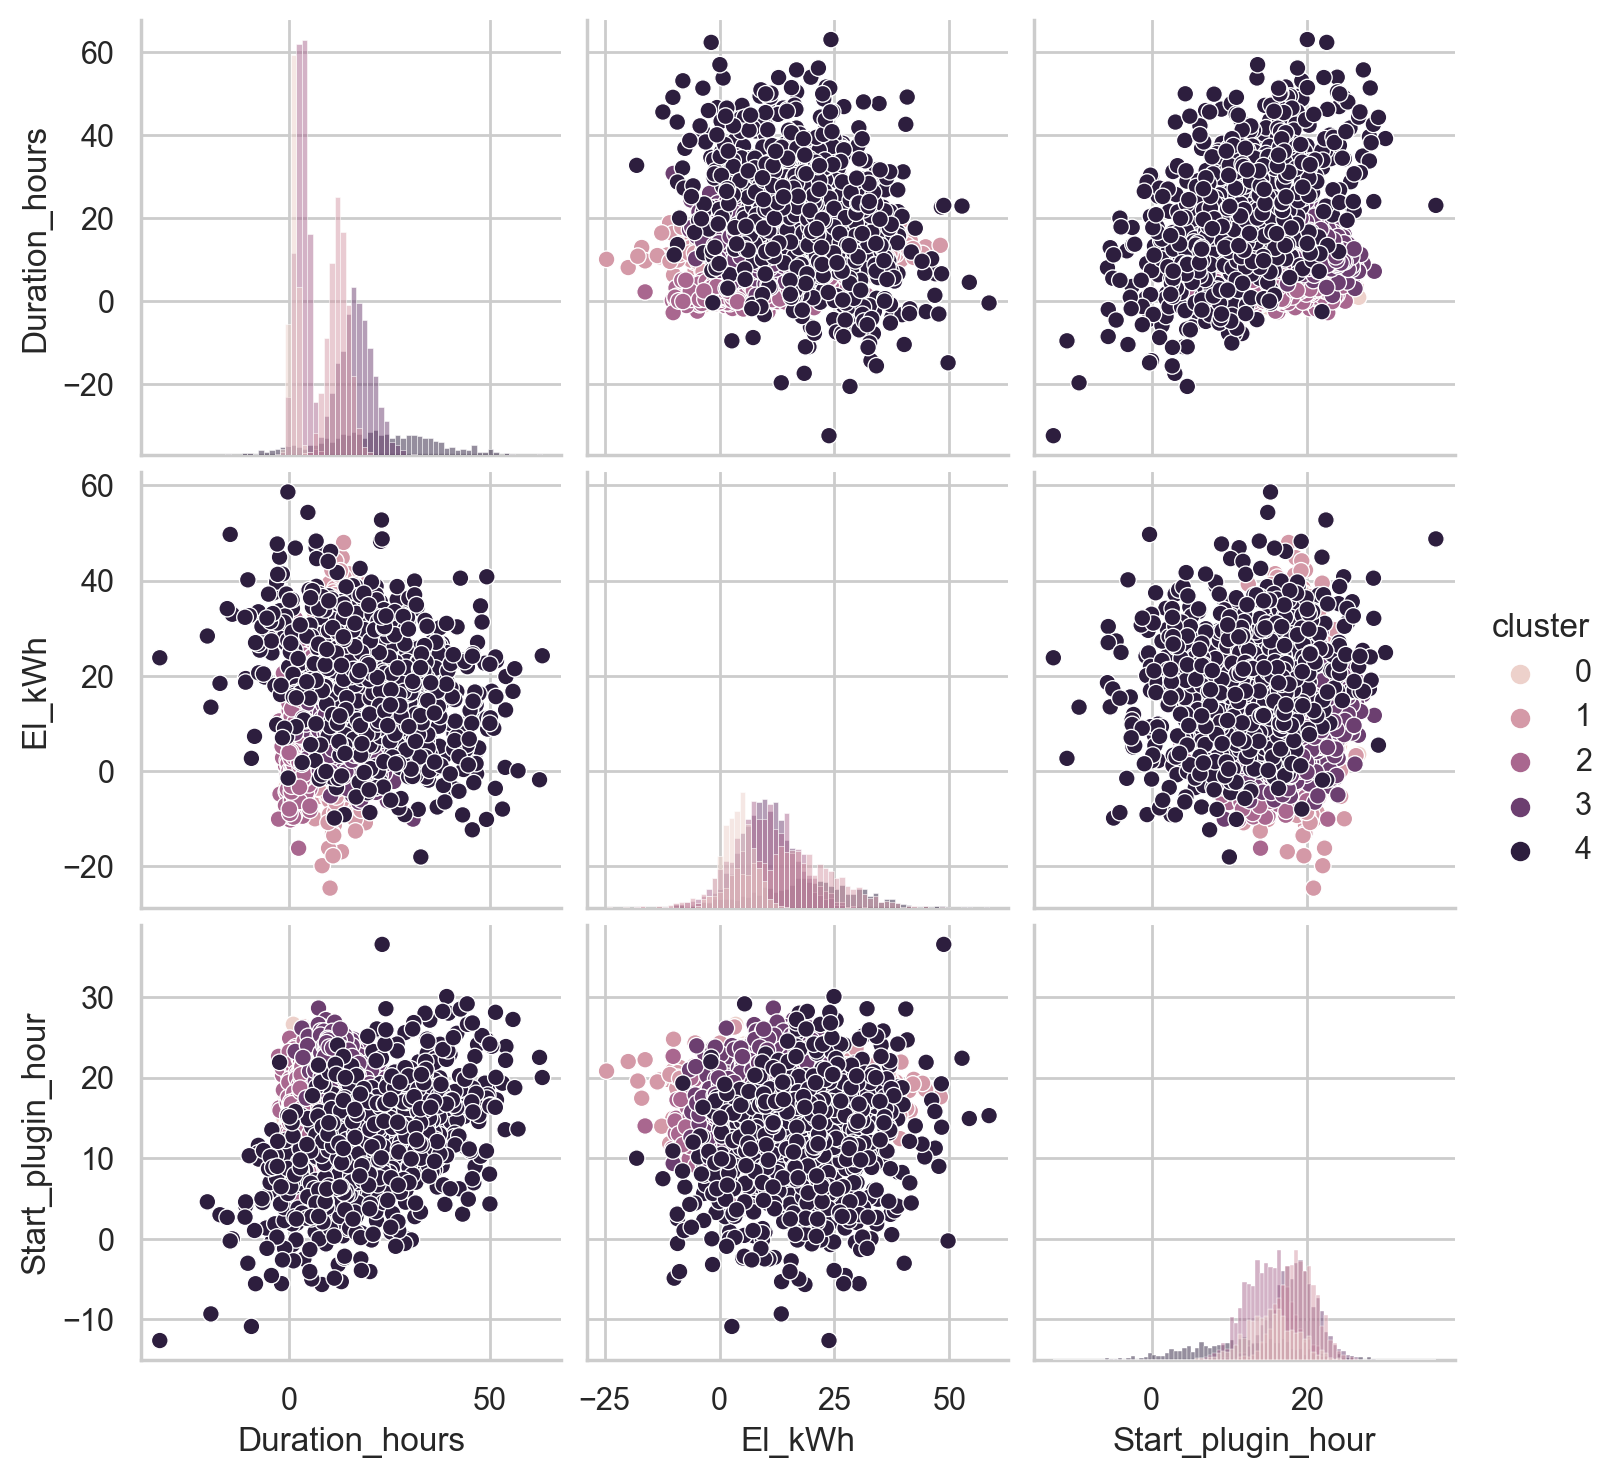

In [16]:
sns.pairplot(data=density_generated_df, hue="cluster", diag_kind="hist");

In [17]:
best_gmm.means_

array([[ 1.16392531,  4.15732963, 15.55131409],
       [12.17650778, 14.8306841 , 18.80966159],
       [ 3.08384075, 10.06875491, 14.9053526 ],
       [16.27800505, 10.29812965, 18.42715724],
       [21.49057927, 18.62968559, 11.51108882]])

In [18]:
best_gmm.covariances_

array([[[ 7.85989753e-01,  2.82947780e+00, -5.14959195e-02],
        [ 2.82947780e+00,  1.01952017e+01, -1.77126922e-01],
        [-5.14959195e-02, -1.77126922e-01,  1.14002606e+01]],

       [[ 6.35053262e+00,  6.27143559e-01, -5.97582332e+00],
        [ 6.27143559e-01,  1.04258538e+02, -3.84789337e-01],
        [-5.97582332e+00, -3.84789337e-01,  6.02636491e+00]],

       [[ 2.39715199e+00,  3.96239938e+00, -6.65121234e-01],
        [ 3.96239938e+00,  4.54795602e+01,  1.32401817e+00],
        [-6.65121234e-01,  1.32401817e+00,  9.09261653e+00]],

       [[ 1.86611264e+01, -4.08398957e+00, -8.16606349e+00],
        [-4.08398957e+00,  3.36760193e+01,  3.73019500e+00],
        [-8.16606349e+00,  3.73019500e+00,  8.18009150e+00]],

       [[ 2.11307146e+02, -6.08413068e+01,  5.19668866e+01],
        [-6.08413068e+01,  1.42458213e+02,  1.72765448e+01],
        [ 5.19668866e+01,  1.72765448e+01,  4.74661553e+01]]])

In [19]:
best_gmm.weights_

array([0.14044231, 0.22174803, 0.27590466, 0.24354931, 0.11835569])

## Compare generated data with sample data

In [20]:
n_sims = 100

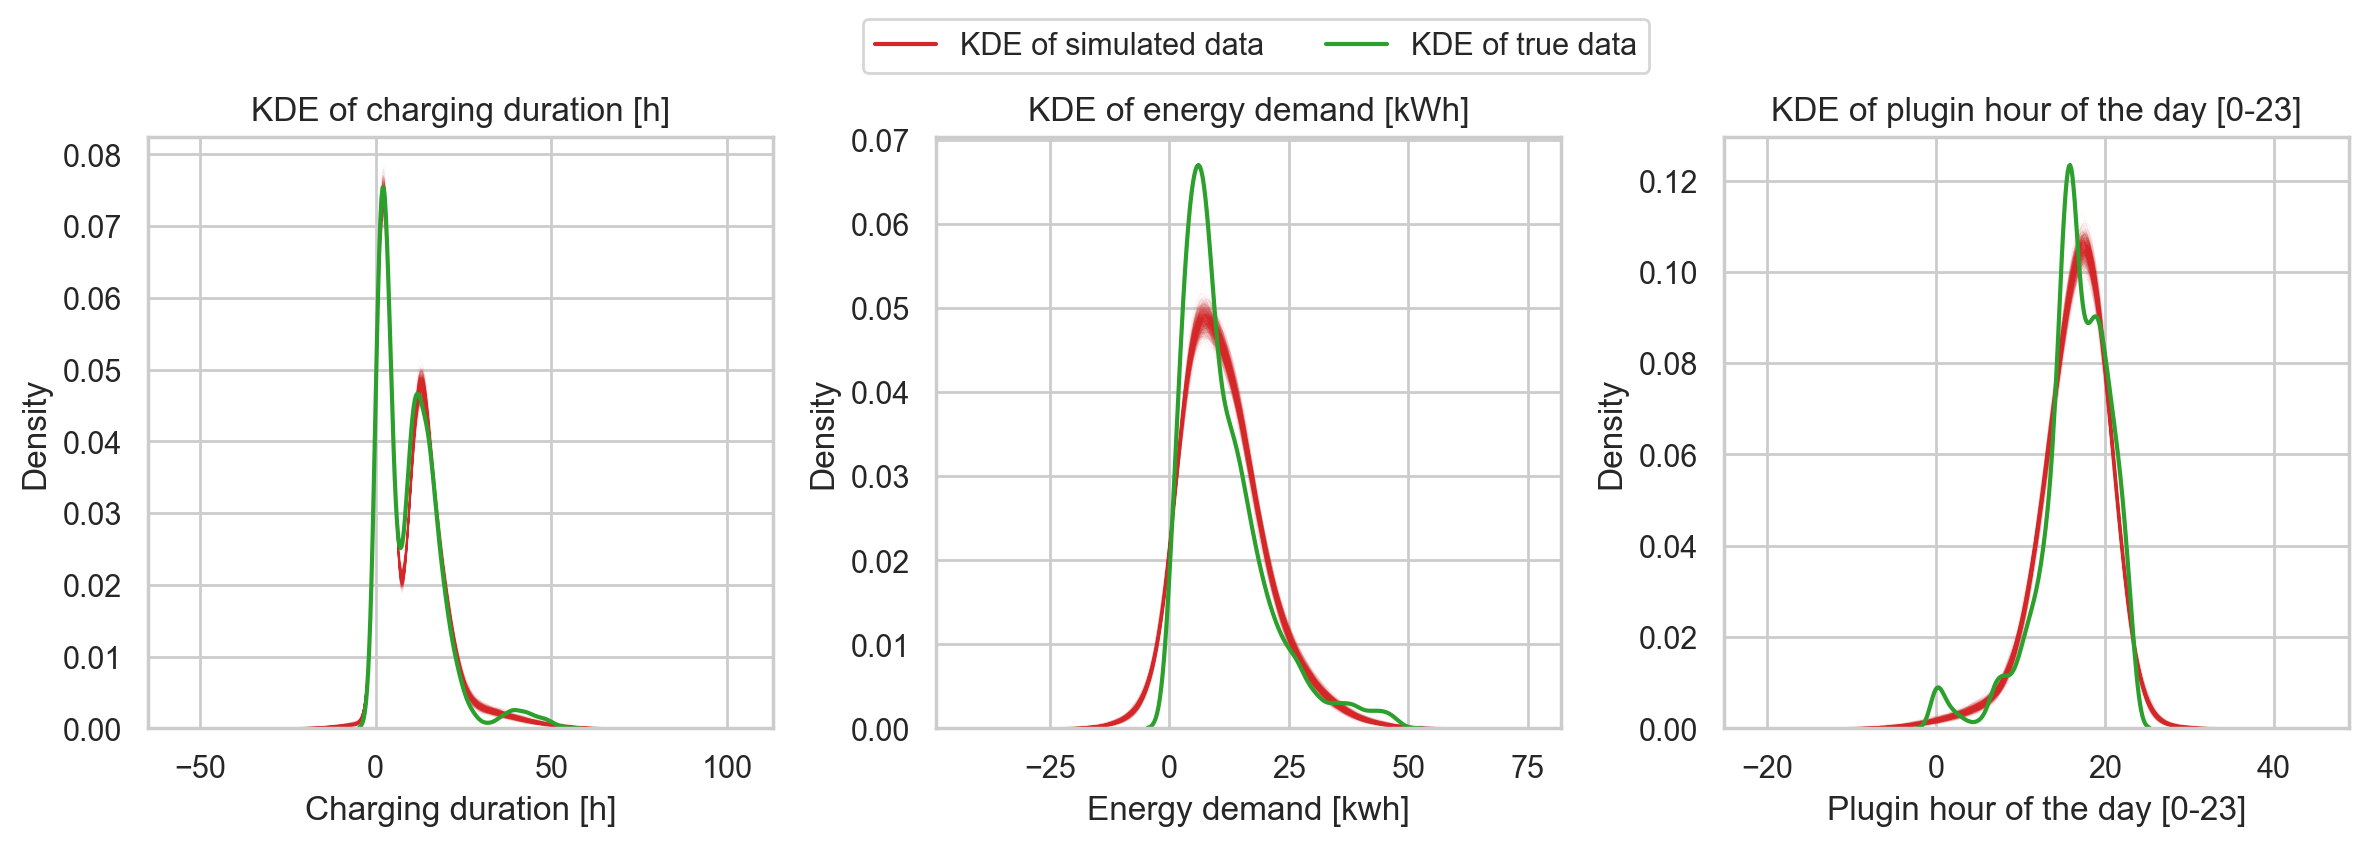

In [21]:
fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
titles = ["charging duration [h]", "energy demand [kWh]", "plugin hour of the day [0-23]"]
for i, ax in enumerate(axs):
    for _ in range(n_sims * 10):
        sample_data, _ = best_gmm.sample(len(density_df))
        sns.kdeplot(sample_data[:, i], color="#d62728", alpha=0.1, lw=0.1, ax=ax)
    sns.kdeplot(density_df[density_df.columns[i]], color="#2ca02c", alpha=1, ax=ax)
    ax.set_title(f"KDE of {titles[i]}")
    ax.set_xlabel(titles[i].capitalize())

legend = fig.legend(
    handles=(
        Line2D([0], [0], color="#d62728", label="KDE of simulated data"),
        Line2D([0], [0], color="#2ca02c", label="KDE of true data"),
    ),
    bbox_to_anchor=(0.7, 1.07),
    bbox_transform=fig.transFigure,
    ncol=2,
)
fig.tight_layout()
fig.savefig("figures/joint_gmm_fit.pdf", bbox_extra_artists=(legend,), bbox_inches="tight");

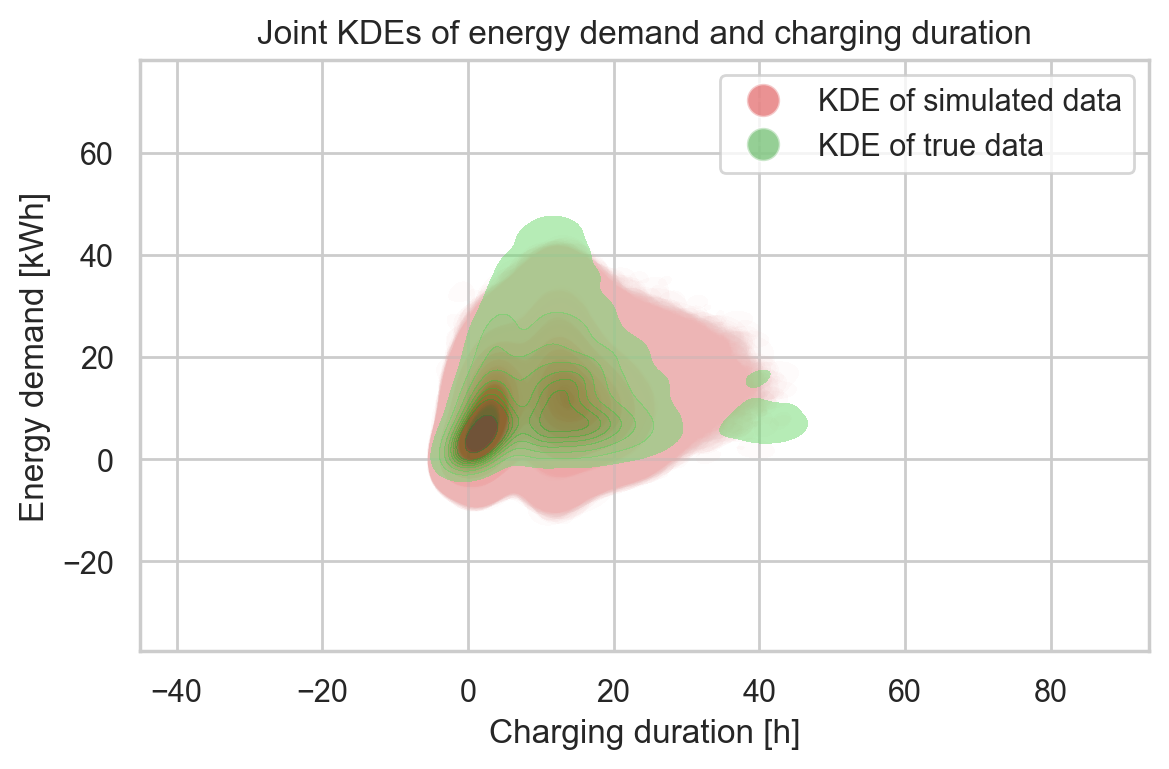

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
for _ in range(n_sims):
    sample_data, _ = best_gmm.sample(len(density_df))
    sns.kdeplot(
        x=sample_data[:, 0],
        y=sample_data[:, 1],
        color="#d62728",
        alpha=0.05,
        ax=ax,
        shade=True,
    )
sns.kdeplot(
    x=density_df["Duration_hours"],
    y=density_df["El_kWh"],
    color="#2ca02c",
    alpha=0.5,
    ax=ax,
    shade=True,
)
legend = ax.legend(
    handles=(
        Line2D(
            [0],
            [0],
            color="w",
            marker="o",
            markerfacecolor="#d62728",
            markersize=12,
            alpha=0.5,
            label="KDE of simulated data",
        ),
        Line2D(
            [0],
            [0],
            color="w",
            marker="o",
            markerfacecolor="#2ca02c",
            markersize=12,
            alpha=0.5,
            label="KDE of true data",
        ),
    ),
)
ax.set_title("Joint KDEs of energy demand and charging duration")
ax.set_xlabel("Charging duration [h]")
ax.set_ylabel("Energy demand [kWh]")
fig.tight_layout()
fig.savefig("figures/joint_gmm_bivariate_fit.pdf", bbox_extra_artists=(legend,), bbox_inches="tight");

## Conditional distribution $p(\text{Duration_hours}, \text{El_kWh} | \text{Start_plugin_hour})$

### True conditional sample distributions

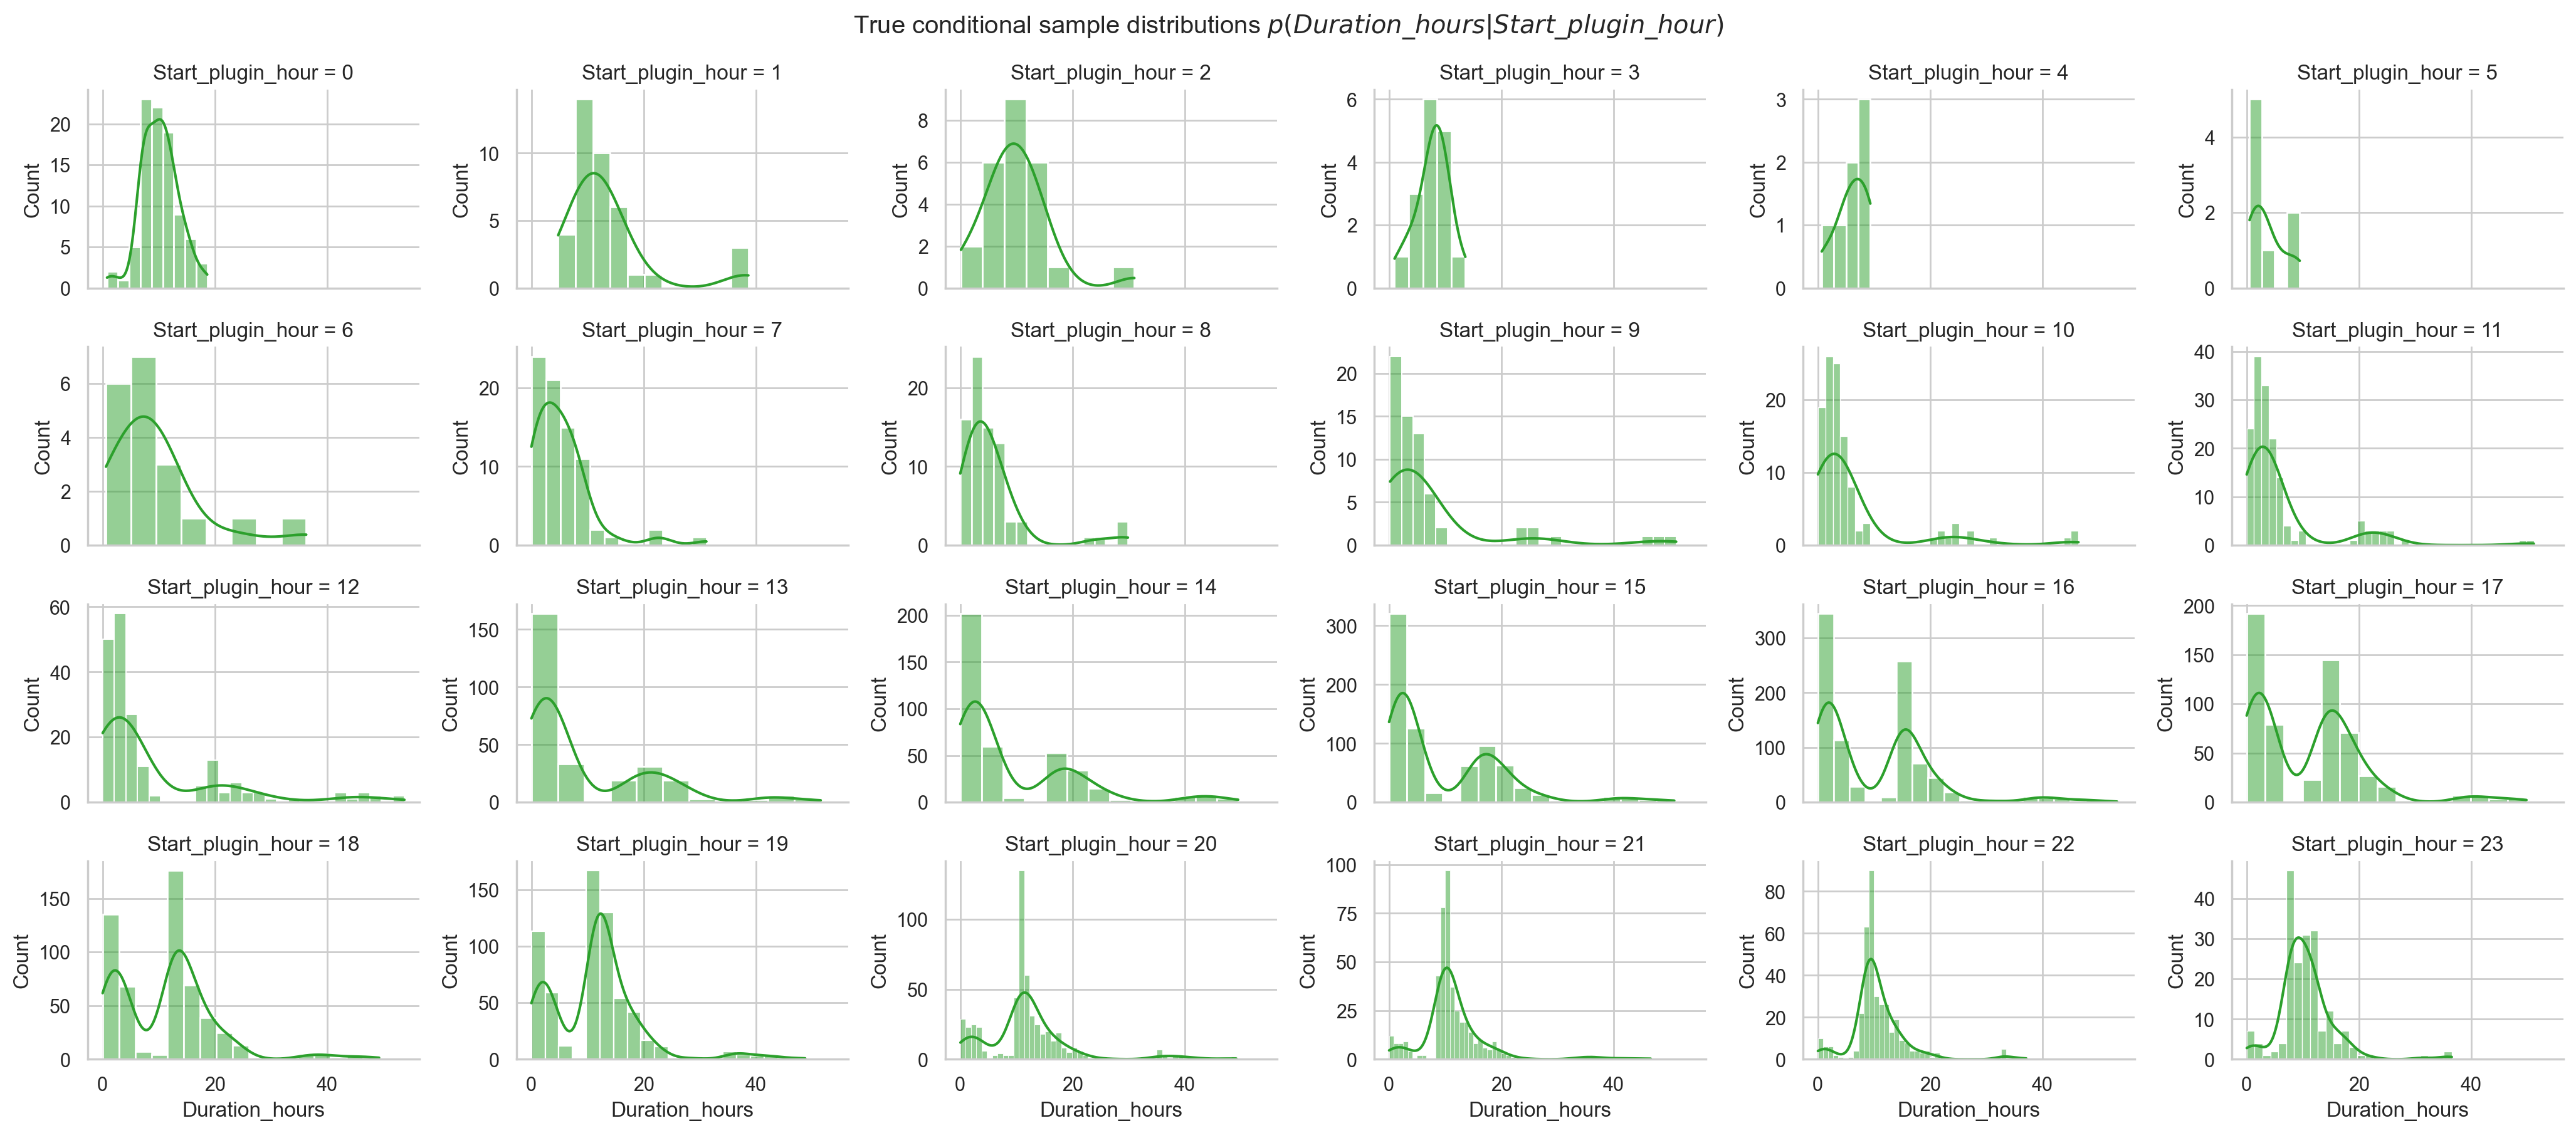

In [23]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "Duration_hours", kde=True, color="#2ca02c")
g.figure.suptitle(r"True conditional sample distributions $p(Duration\_hours | Start\_plugin\_hour)$")
g.figure.tight_layout();

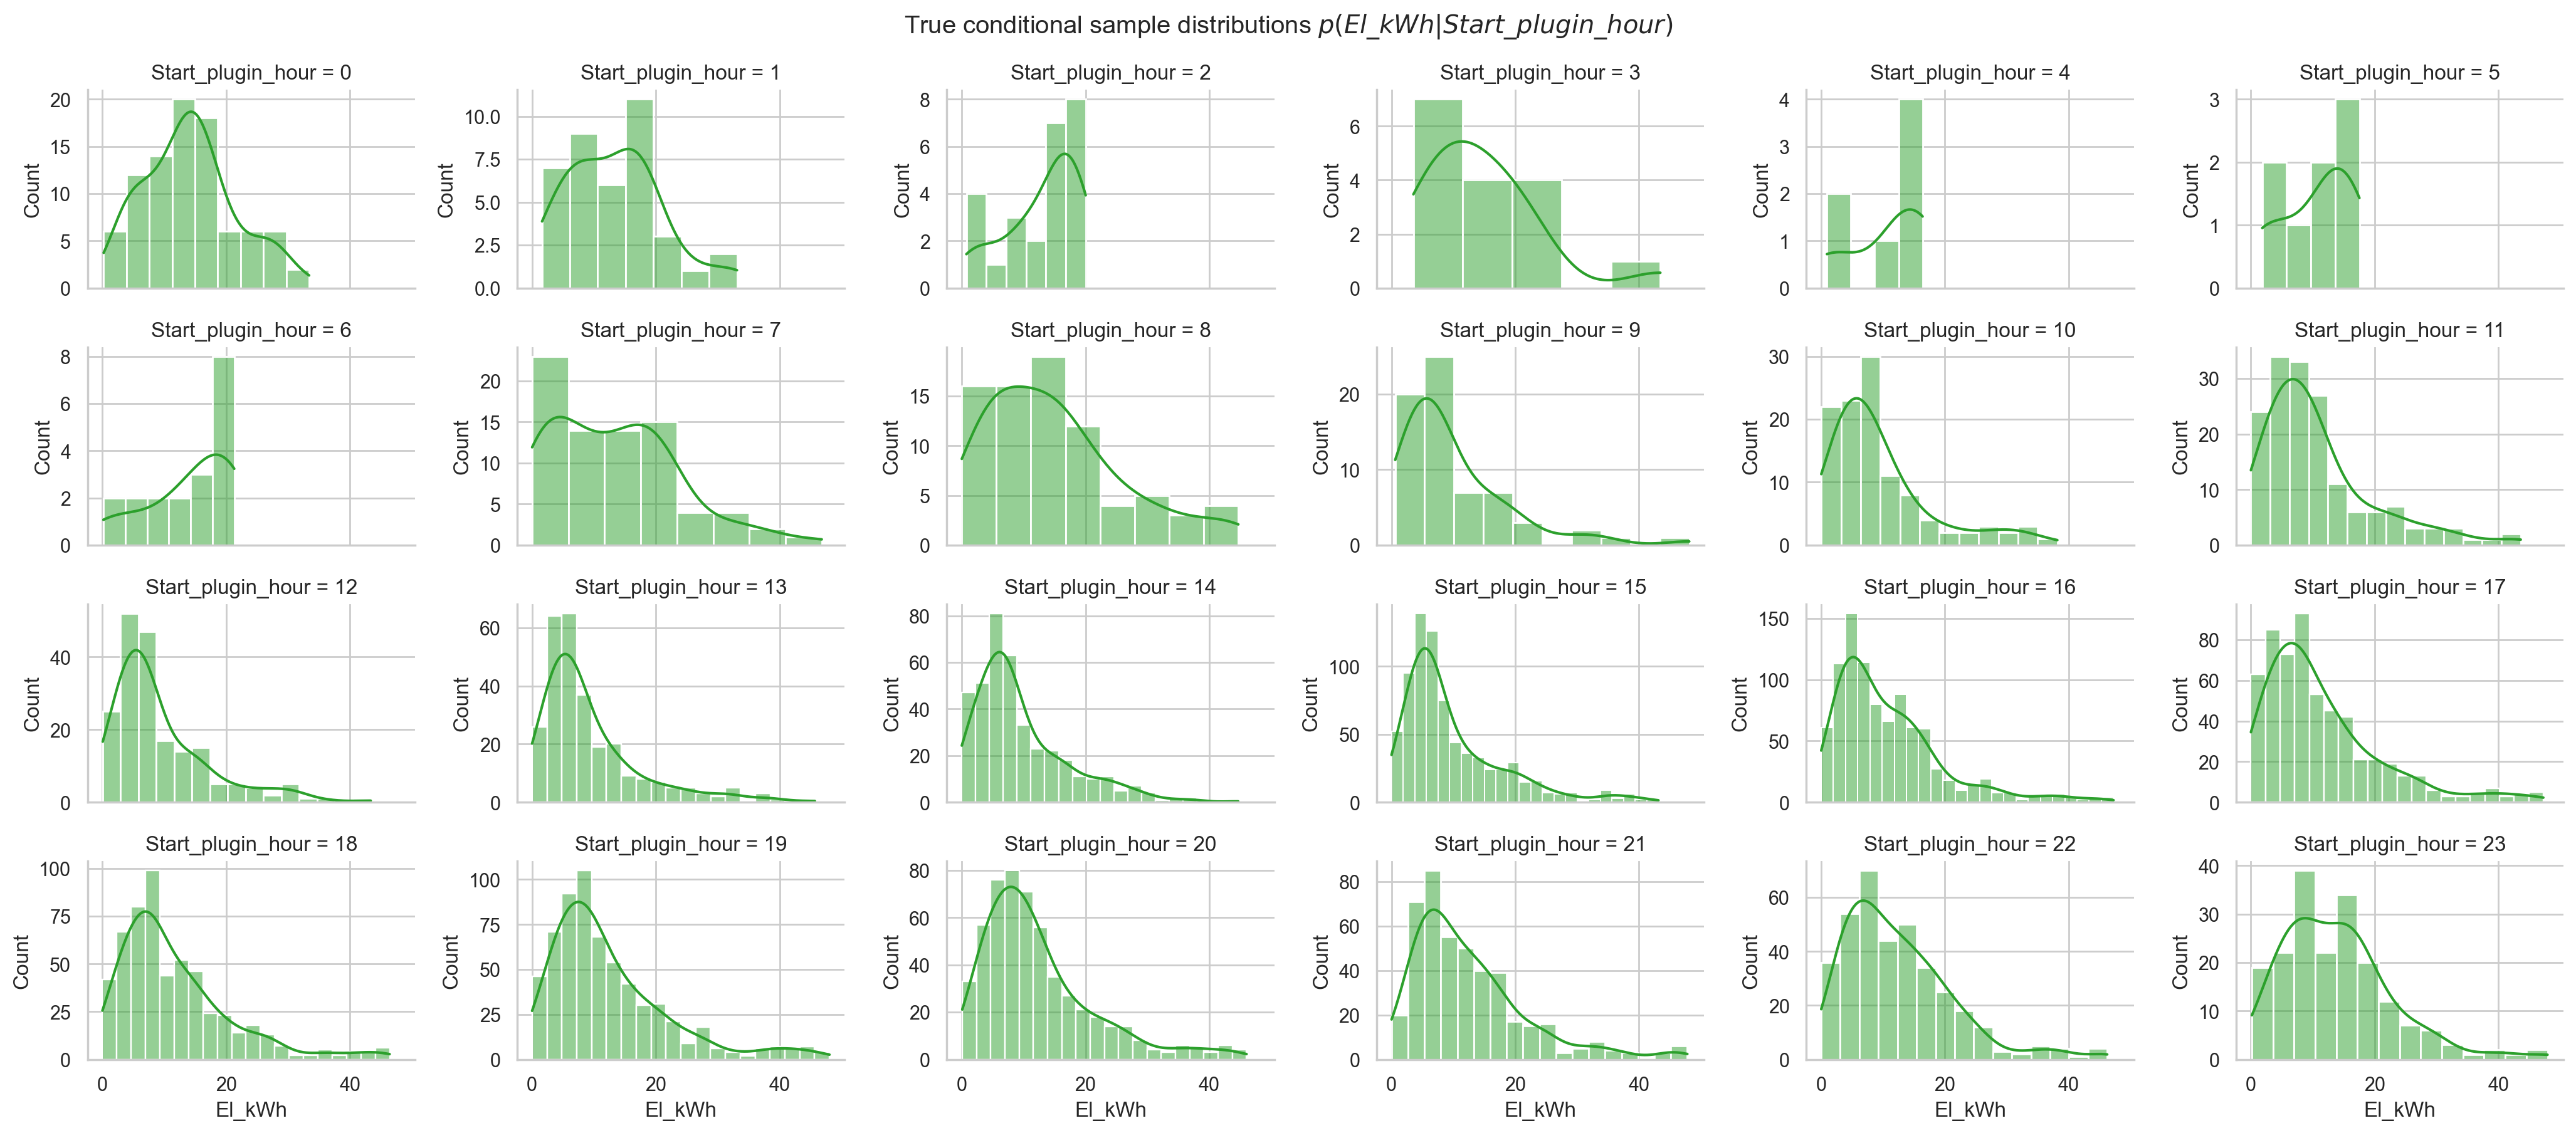

In [24]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "El_kWh", kde=True, color="#2ca02c")
g.figure.suptitle(r"True conditional sample distributions $p(El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

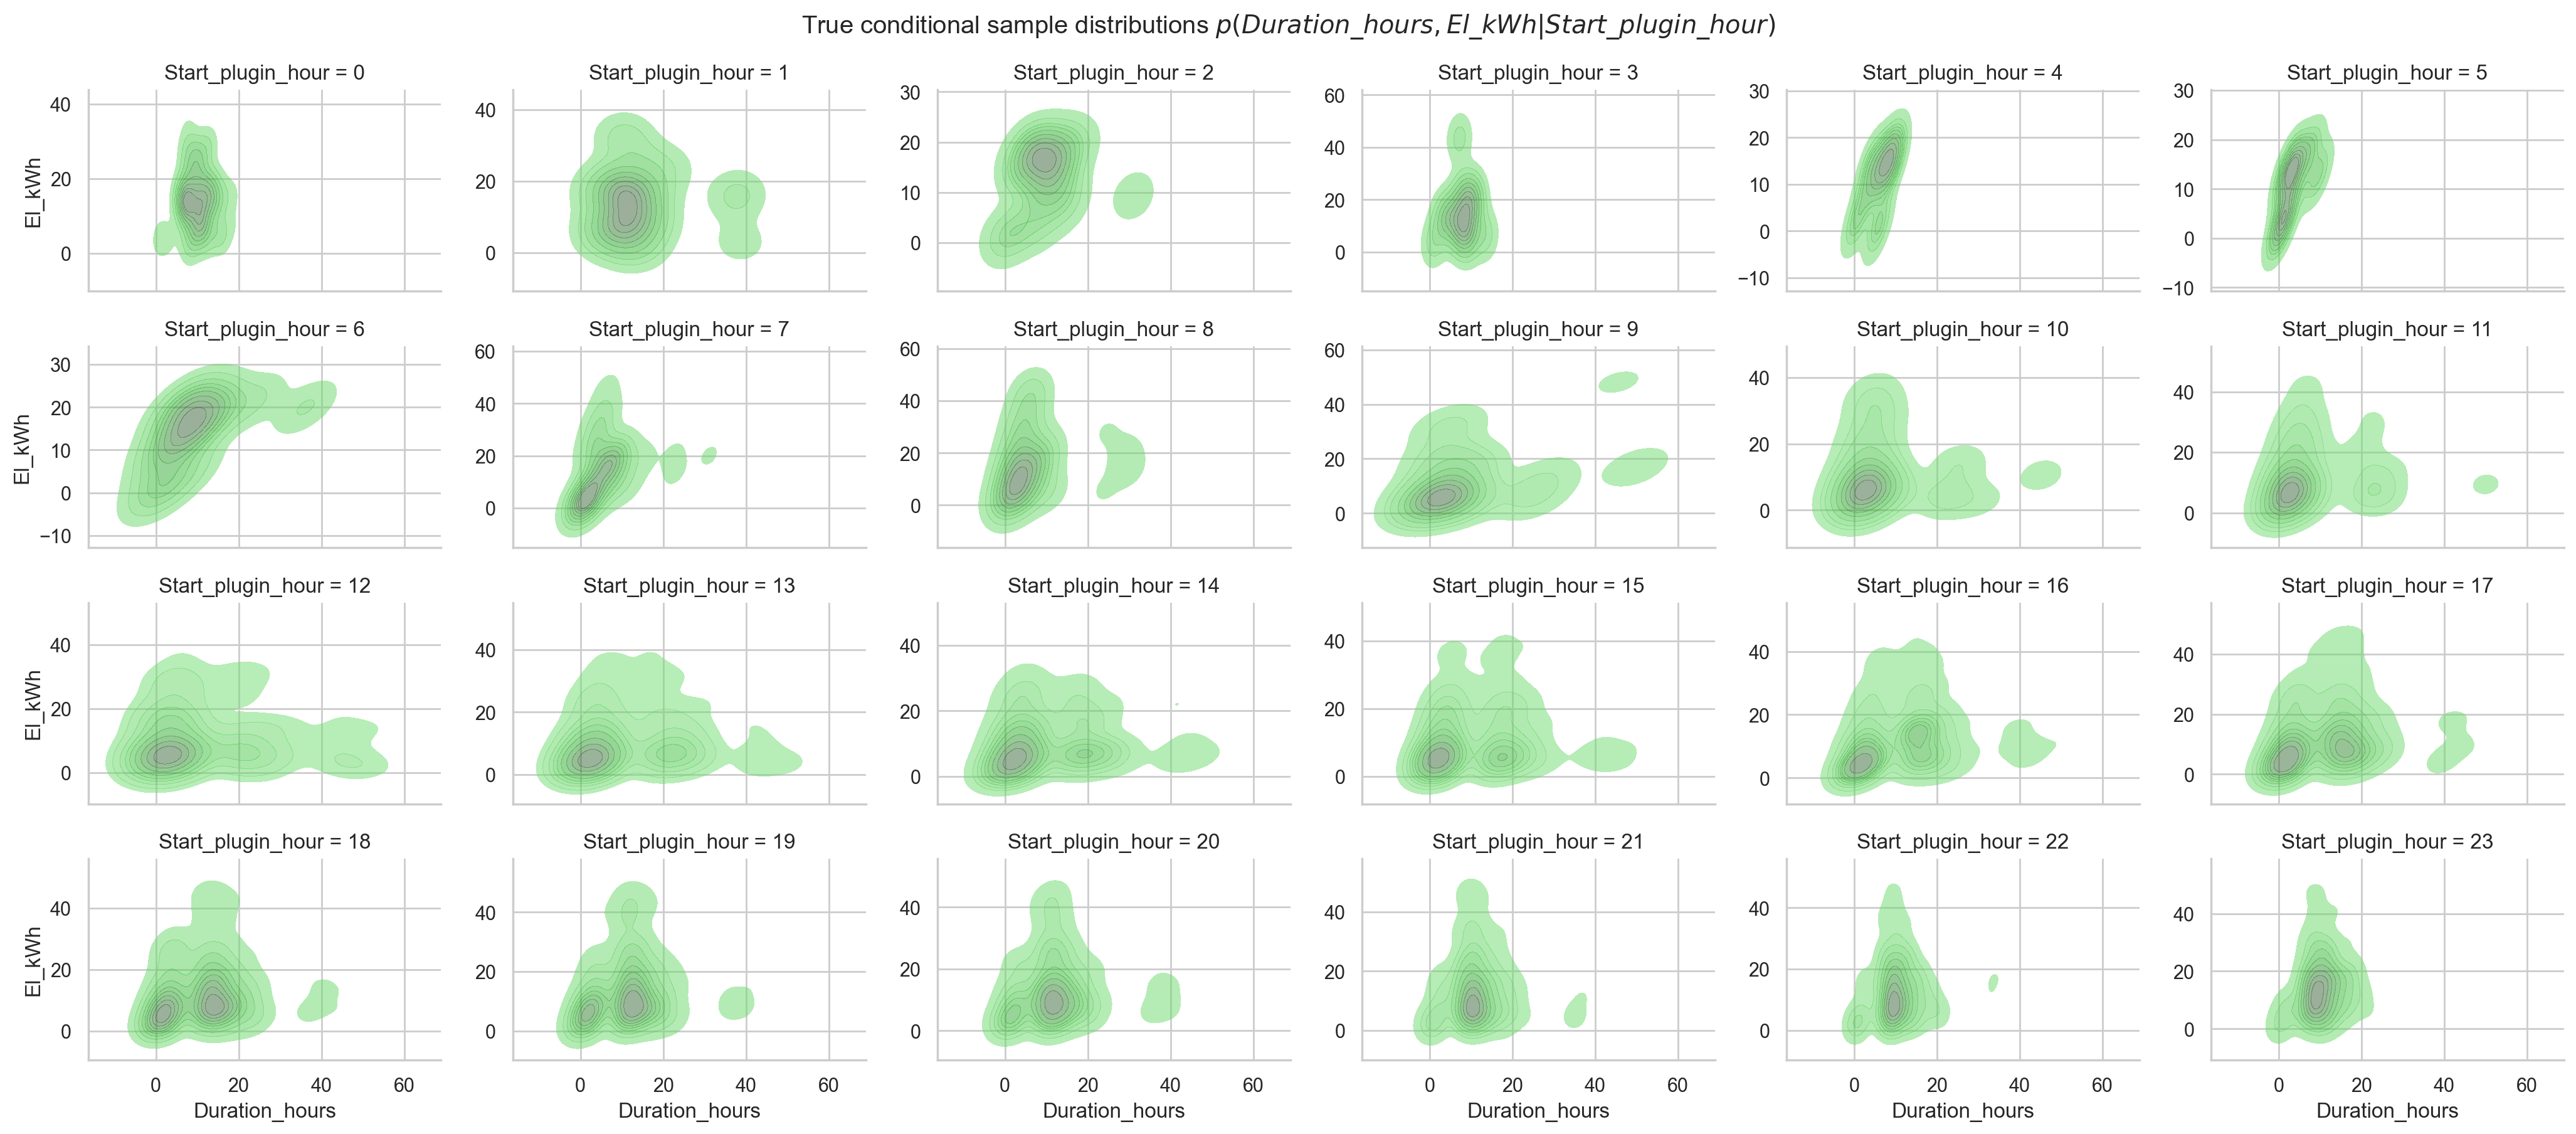

In [25]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.kdeplot, "Duration_hours", "El_kWh", shade=True, alpha=0.5, color="#2ca02c")
g.figure.suptitle(r"True conditional sample distributions $p(Duration\_hours, El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

### Estimated conditional distributions by GMM
Now, we want to calculate the conditional distribution $p(\text{Duration_hours}, \text{El_kWh} | \text{Start_plugin_hour})$ estimated by the GMM. To do that, we have to derive the conditional distributions for each GMM mixture component. Luckily, the conditional distribution for one set of variables, given all other variables of a joint multivariate normal distribition is a (multivariate) normal distribution with well defined moments.

The formula to derive the conditional distribution $p(X | Y) \sim \mathcal{N}$ for a joint multivariate normal distribution $p(X, Y) \sim \mathcal{MVN}$ is on Wikipedia: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions.

In [26]:
mvns = [MultivariateNormal(mean, cov) for mean, cov in zip(best_gmm.means_, best_gmm.covariances_)]
weights = np.array(best_gmm.weights_)

In [27]:
cond_gmm = ConditionalMvnMixture(mvns, weights)
cond_gmm.partition(2)

In [28]:
n_sims = 100

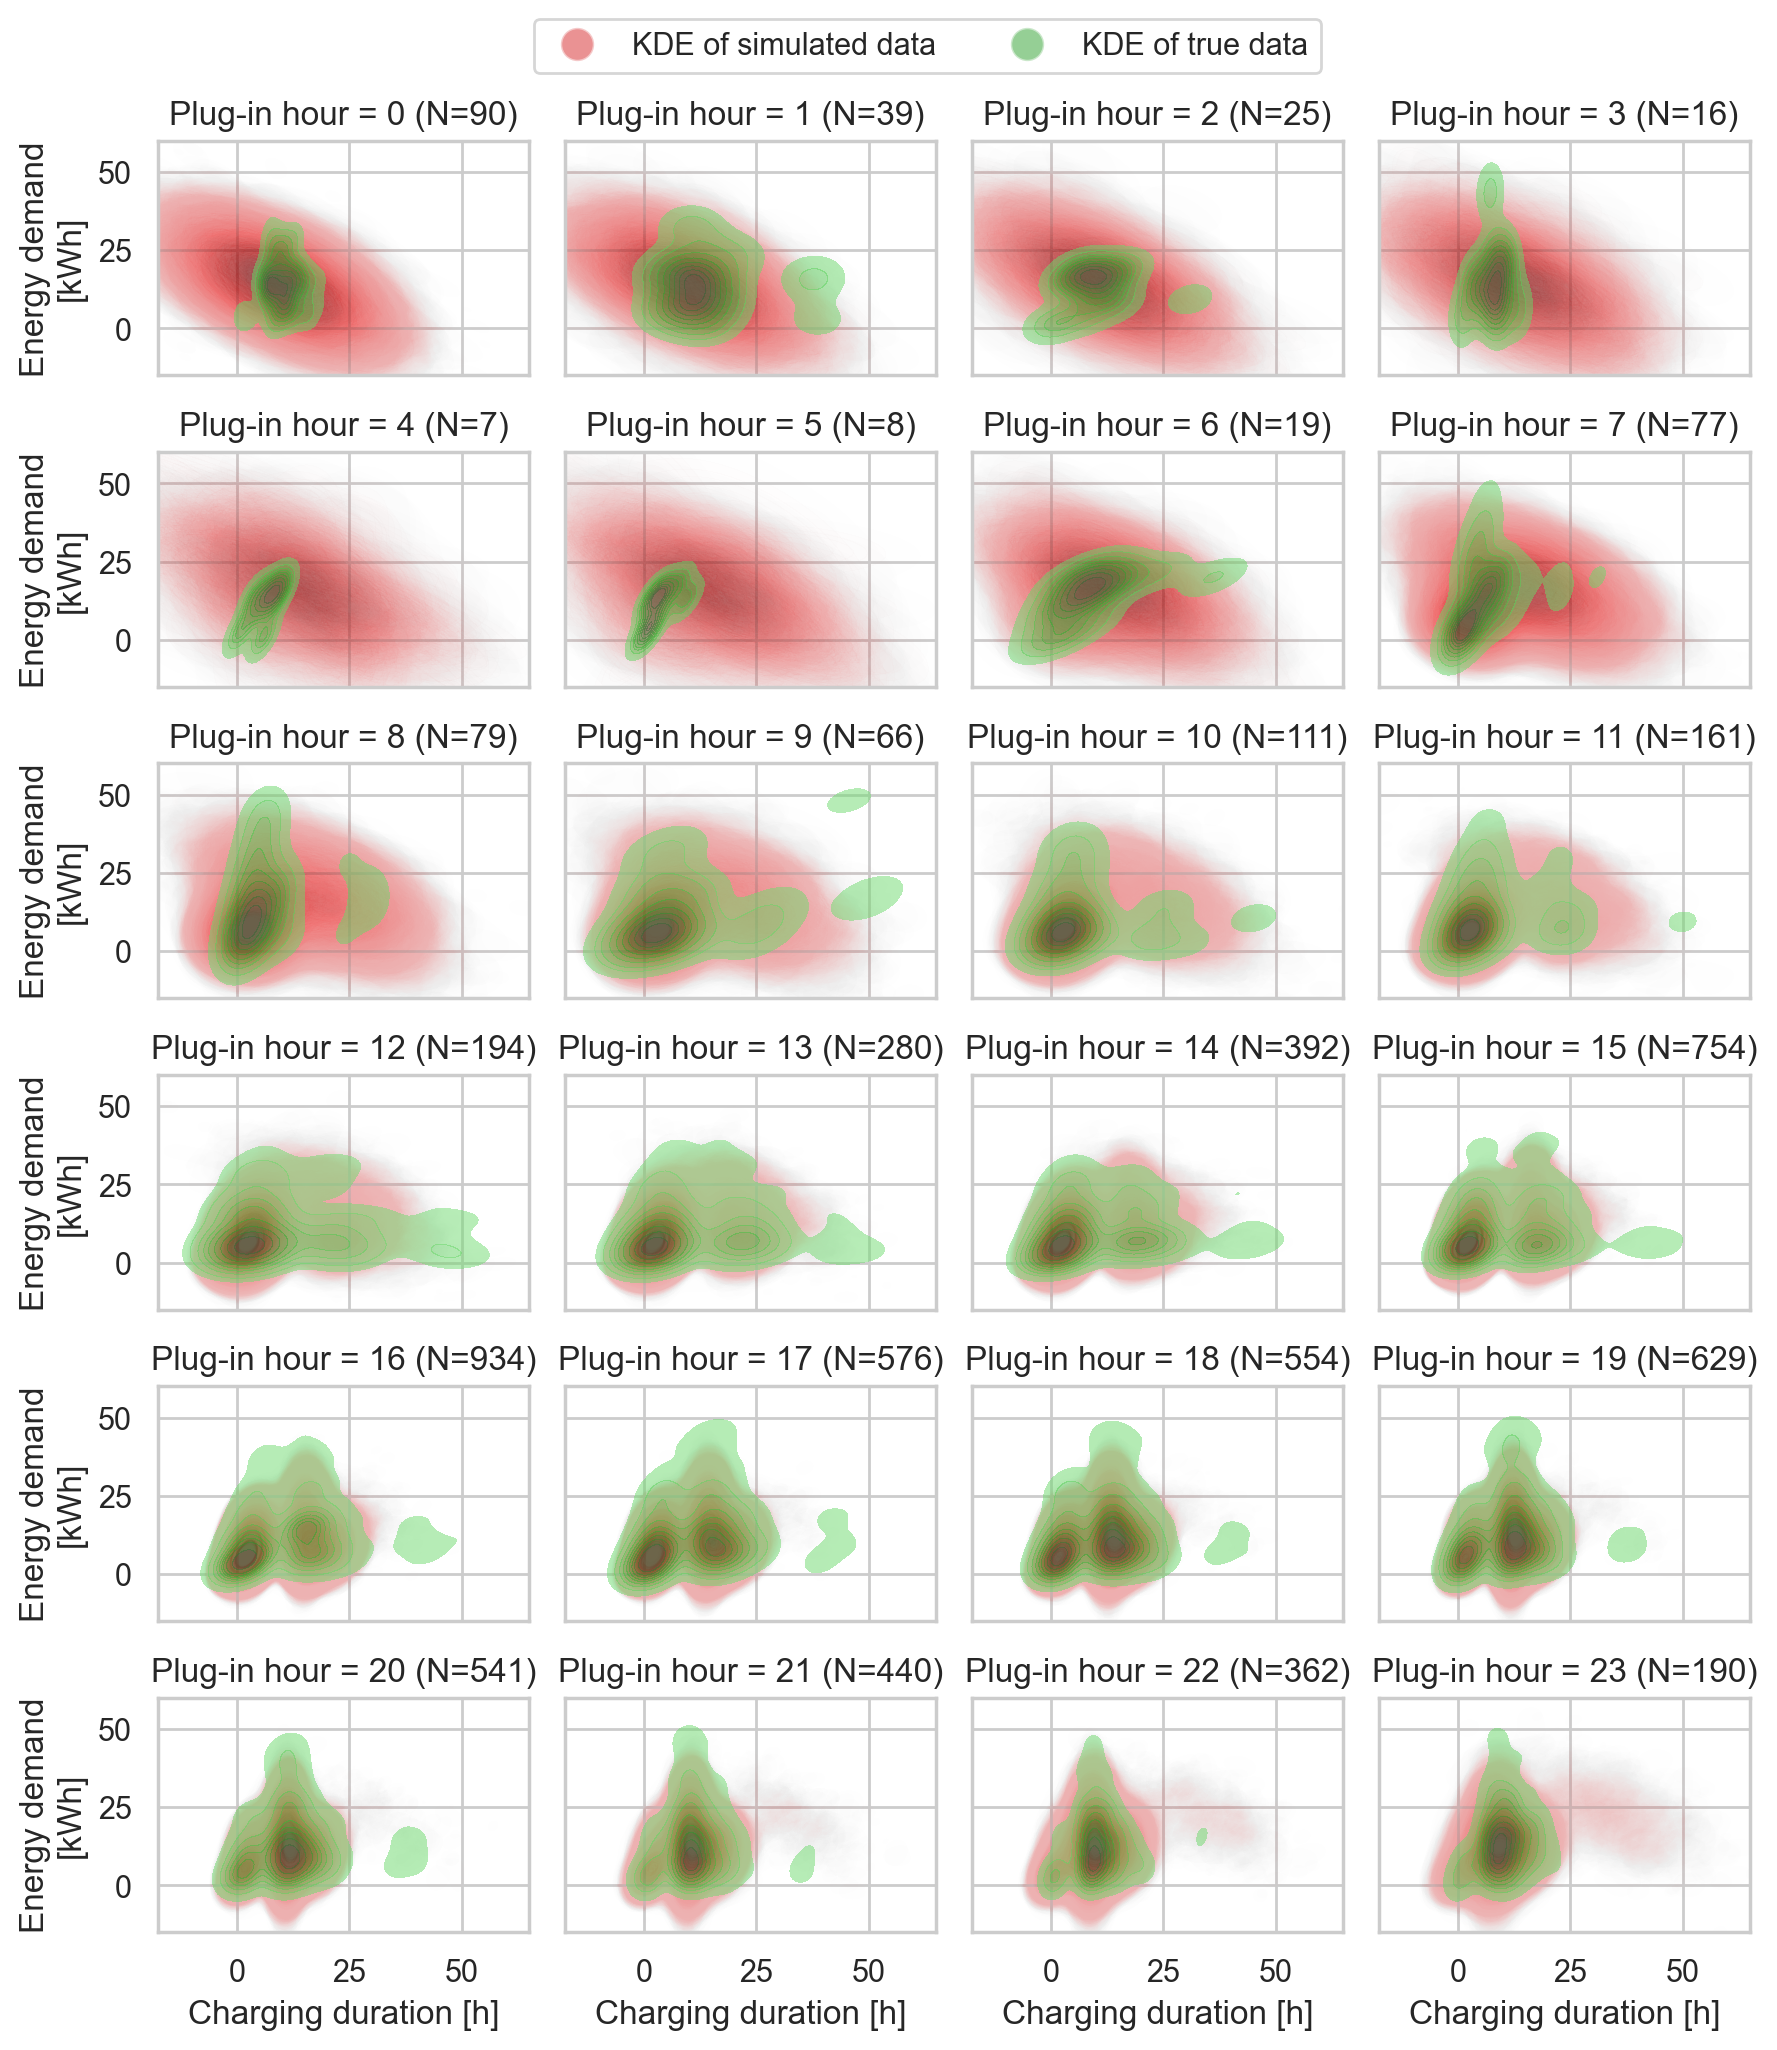

In [29]:
fig, ax = plt.subplots(figsize=(9, 10), nrows=6, ncols=4, sharex=True, sharey=True)
for hour in range(24):
    current_ax = ax.flat[hour]
    true_data = density_df[density_df["Start_plugin_hour"] == hour]
    for _ in range(n_sims):
        sample_data = cond_gmm.sample_cond(0, hour, len(true_data))
        # We rasterize this because the PDF would be huge otherwise
        sns.kdeplot(
            x=sample_data[:, 0],
            y=sample_data[:, 1],
            color="#d62728",
            alpha=0.01,
            ax=current_ax,
            shade=True,
        ).set_rasterized(True)
    sns.kdeplot(
        x=true_data["Duration_hours"], y=true_data["El_kWh"], color="#2ca02c", alpha=0.5, ax=current_ax, shade=True
    )
    current_ax.set_title(f"Plug-in hour = {hour} (N={len(true_data)})")
    current_ax.set_xlabel("Charging duration [h]")
    current_ax.set_ylabel("Energy demand\n[kWh]")
    current_ax.set_xlim(-17.5, 65)
    current_ax.set_ylim(-15, 60)
legend = fig.legend(
    handles=(
        Line2D(
            [0],
            [0],
            color="w",
            marker="o",
            markerfacecolor="#d62728",
            markersize=12,
            alpha=0.5,
            label="KDE of simulated data",
        ),
        Line2D(
            [0],
            [0],
            color="w",
            marker="o",
            markerfacecolor="#2ca02c",
            markersize=12,
            alpha=0.5,
            label="KDE of true data",
        ),
    ),
    bbox_to_anchor=(0.75, 1.03),
    bbox_transform=fig.transFigure,
    ncol=2,
)
fig.tight_layout()
fig.savefig("figures/cond_gmm_bivariate_fit.pdf", bbox_extra_artists=(legend,), bbox_inches="tight", dpi=300);

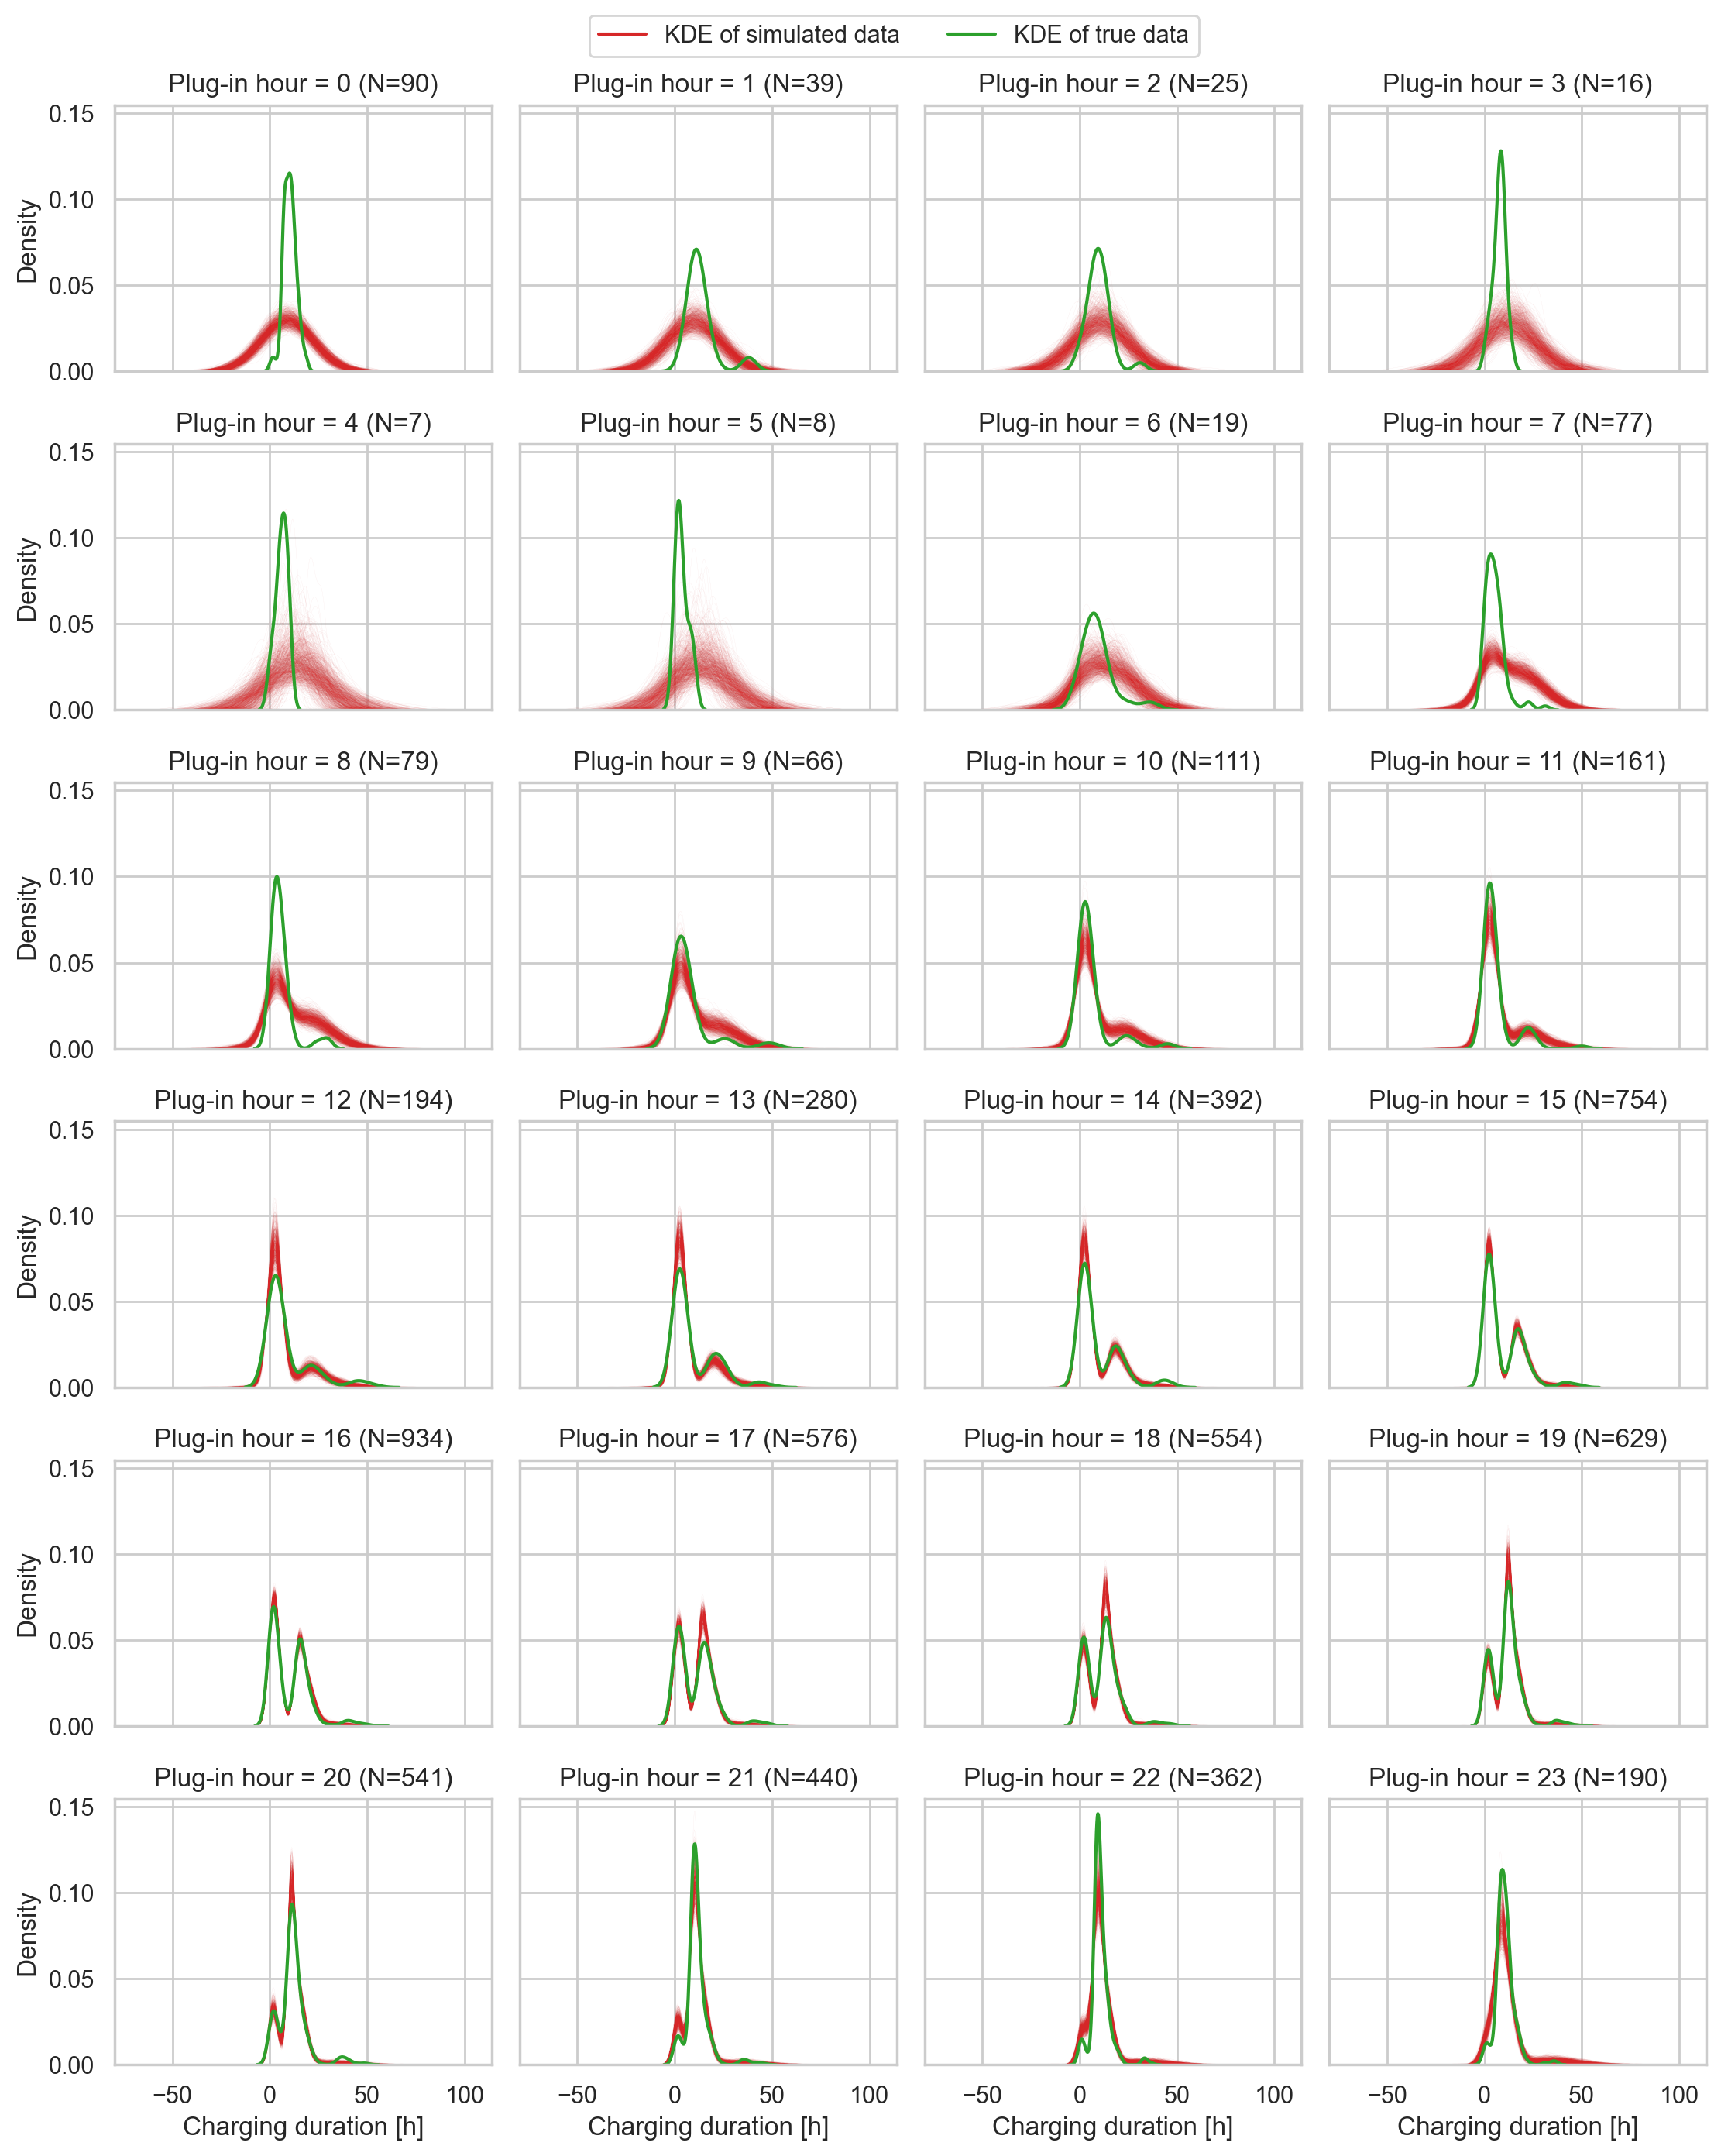

In [30]:
fig, ax = plt.subplots(figsize=(11.27, 13.69), nrows=6, ncols=4, sharex=True, sharey=True)
for hour in range(24):
    current_ax = ax.flat[hour]
    true_data = density_df[density_df["Start_plugin_hour"] == hour]
    for _ in range(n_sims * 10):
        sample_data = cond_gmm.sample_cond(0, hour, len(true_data))
        sns.kdeplot(sample_data[:, 0], color="#d62728", alpha=0.1, lw=0.1, ax=current_ax)
    sns.kdeplot(true_data["Duration_hours"], color="#2ca02c", alpha=1, ax=current_ax)
    current_ax.set_title(f"Plug-in hour = {hour} (N={len(true_data)})")
    current_ax.set_xlabel("Charging duration [h]")
legend = fig.legend(
    handles=(
        Line2D([0], [0], color="#d62728", label="KDE of simulated data"),
        Line2D([0], [0], color="#2ca02c", label="KDE of true data"),
    ),
    bbox_to_anchor=(0.7, 1.02),
    bbox_transform=fig.transFigure,
    ncol=2,
)
fig.tight_layout()
fig.savefig("figures/cond_gmm_duration_fit.pdf", bbox_extra_artists=(legend,), bbox_inches="tight");

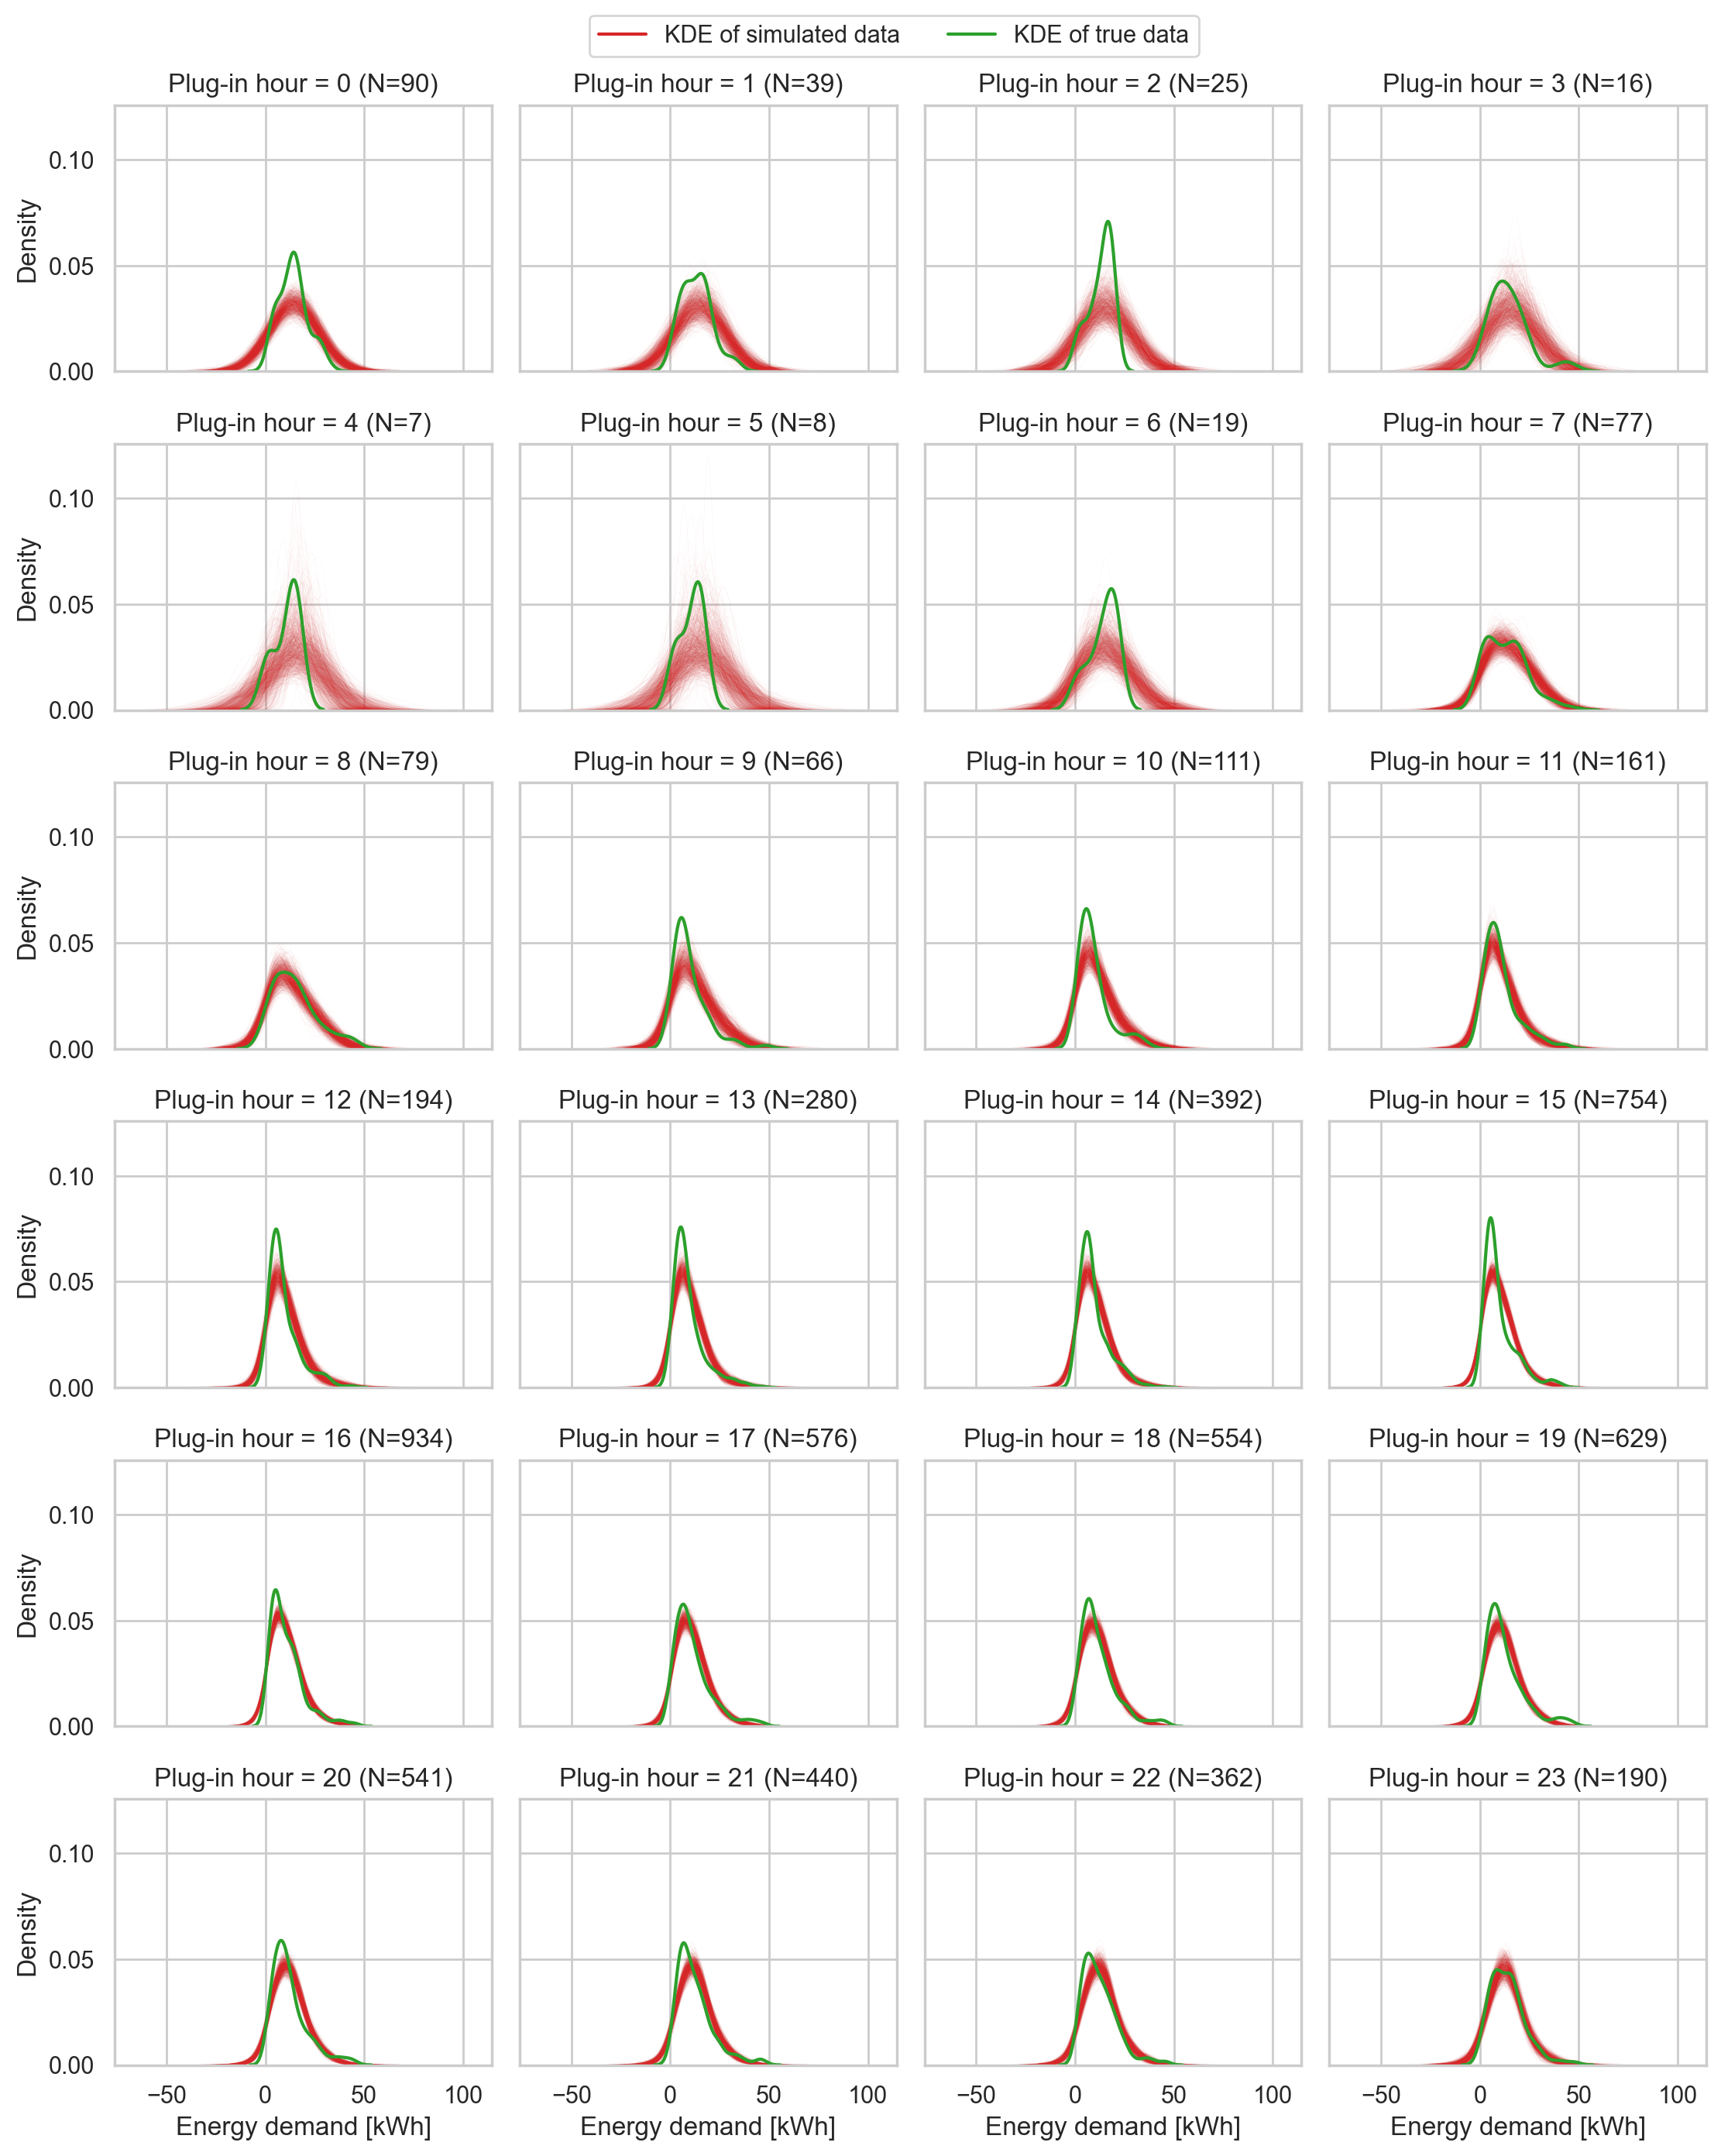

In [31]:
fig, ax = plt.subplots(figsize=(11.27, 13.69), nrows=6, ncols=4, sharex=True, sharey=True)
for hour in range(24):
    current_ax = ax.flat[hour]
    true_data = density_df[density_df["Start_plugin_hour"] == hour]
    for _ in range(n_sims * 10):
        sample_data = cond_gmm.sample_cond(0, hour, len(true_data))
        sns.kdeplot(sample_data[:, 1], color="#d62728", alpha=0.1, lw=0.1, ax=current_ax)
    sns.kdeplot(true_data["El_kWh"], color="#2ca02c", alpha=1, ax=current_ax)
    current_ax.set_title(f"Plug-in hour = {hour} (N={len(true_data)})")
    current_ax.set_xlabel("Energy demand [kWh]")
legend = fig.legend(
    handles=(
        Line2D([0], [0], color="#d62728", label="KDE of simulated data"),
        Line2D([0], [0], color="#2ca02c", label="KDE of true data"),
    ),
    bbox_to_anchor=(0.7, 1.02),
    bbox_transform=fig.transFigure,
    ncol=2,
)
fig.tight_layout()
fig.savefig("figures/cond_gmm_energy_fit.pdf", bbox_extra_artists=(legend,), bbox_inches="tight");

## Marginal distribution $p(\text{Start_plugin_hour})$
This represents the probability that someone plugs-in their vehicle to an EV charger at the given hour. In a population model this can be multiplied by the size of the population of chargers.

**For example:** If we have 1000 EV chargers and the probability of charging is 0.2 at hour 12, it means that 200 new vehicles plug-in at 12 o'clock.

In [32]:
# This calculates the analytical density of a multivariate normal mixture pdf
def normal_mixture_pdf(x, loc, scale, weights):
    density = np.zeros_like(x)
    for mu, sigma, pi in zip(loc, scale, weights):
        density += pi * multivariate_normal.pdf(x, mean=mu, cov=sigma)
    return density

In [33]:
pop_size = 1000

In [34]:
# True marginal mixture density moments
loc = list(map(lambda mvn: mvn.marg_dist(1)[0], cond_gmm.mvns))
scale = list(map(lambda mvn: mvn.marg_dist(1)[1][0], cond_gmm.mvns))
weights = cond_gmm.weights
x_linspace = np.linspace(0, 23, 1000)

In [35]:
# Sampling the marginal density
plugin_hour_samples = cond_gmm.sample_marg(1, pop_size)
plugin_hour_samples = plugin_hour_samples[(plugin_hour_samples >= 0) & (plugin_hour_samples <= 23)]

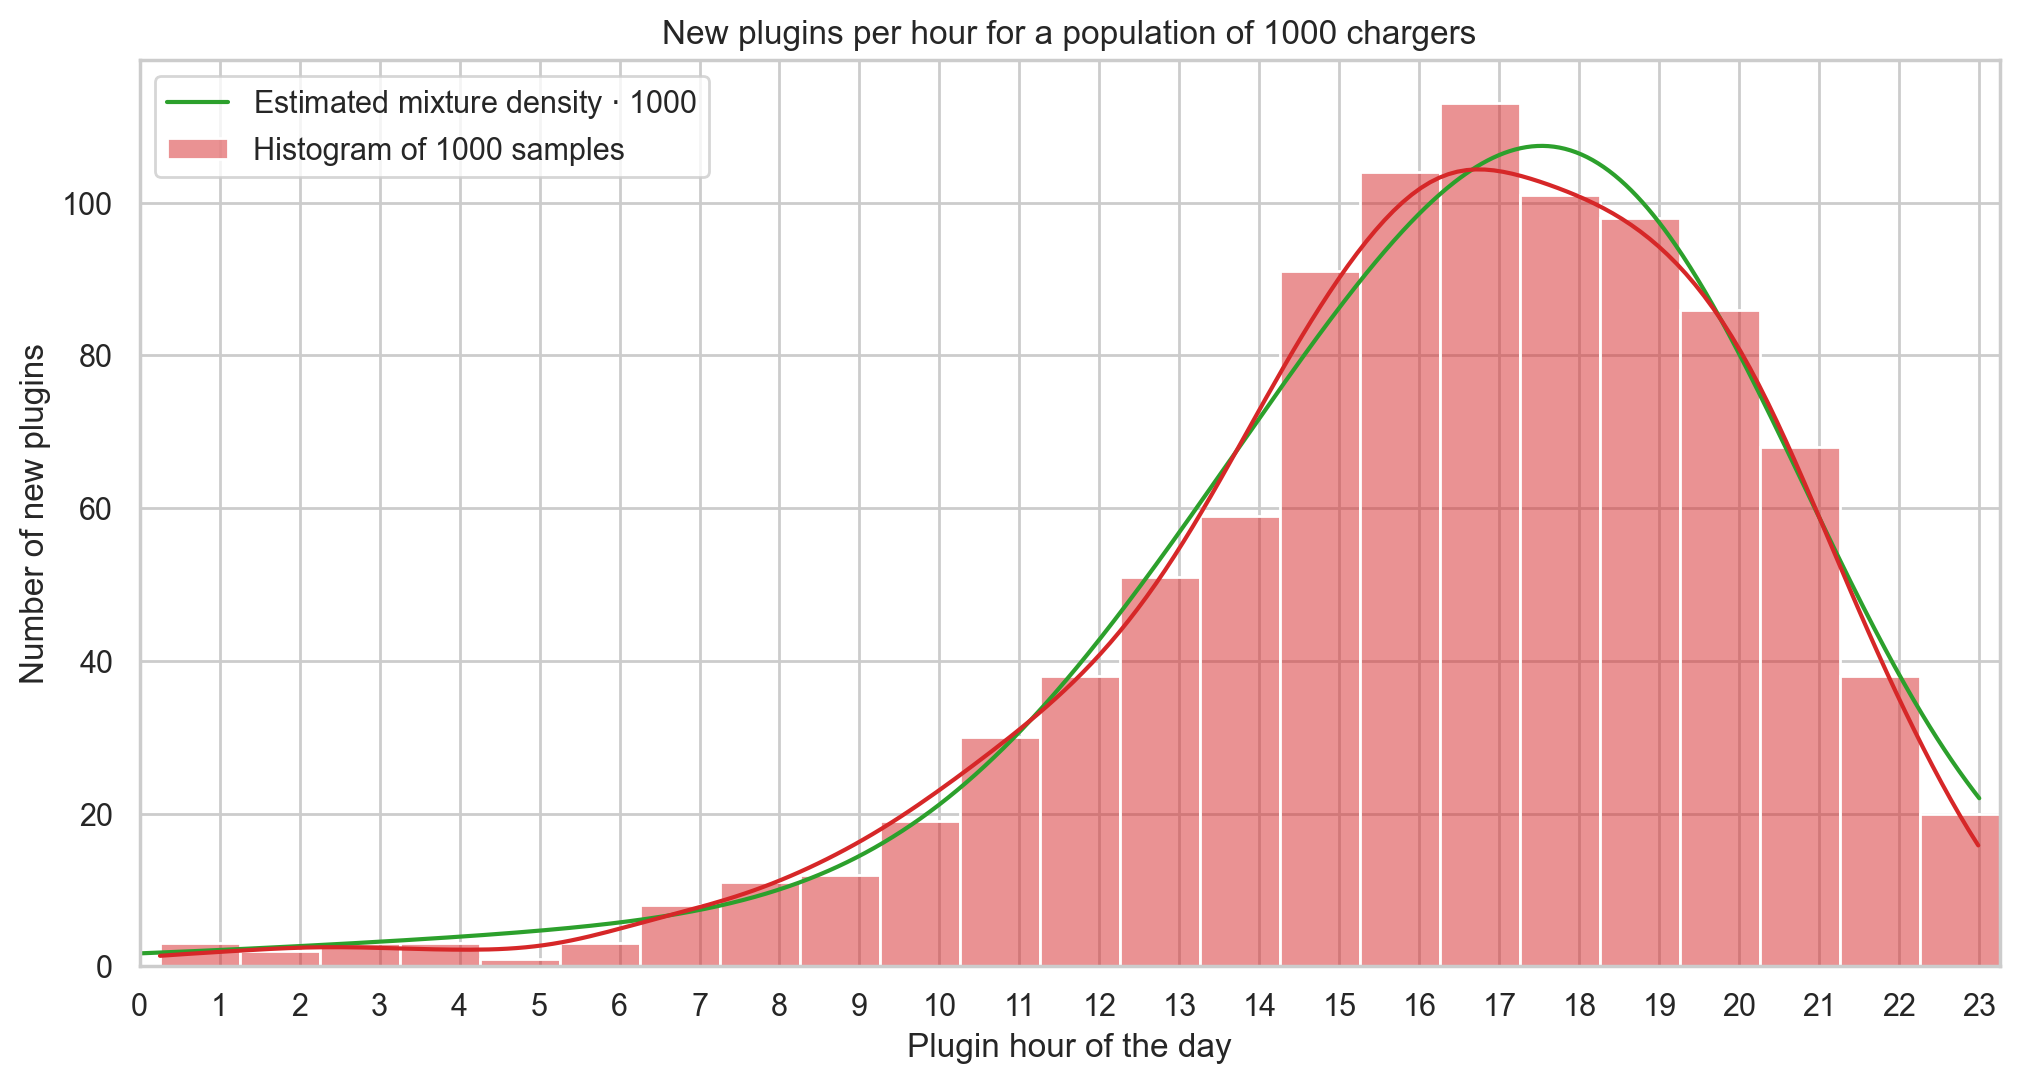

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    x=x_linspace,
    y=normal_mixture_pdf(x_linspace, loc, scale, weights) * pop_size,
    color="#2ca02c",
    ax=ax,
    label=f"Estimated mixture density $\cdot$ {pop_size}",
)
sns.histplot(
    plugin_hour_samples, kde=True, bins=24, binwidth=1, color="#d62728", ax=ax, label=f"Histogram of {pop_size} samples"
)
ax.set_xticks(range(24))
ax.set_xmargin(0)
ax.set_xlabel("Plugin hour of the day")
ax.set_ylabel("Number of new plugins")
ax.legend()
ax.set_title(f"New plugins per hour for a population of {pop_size} chargers");

## Export conditional distributions to XML file

In [37]:
exporter = ConditionalMvnMixtureExporter(
    root_name="residentialEv",
    cond_mvn_mixture=cond_gmm,
    conditionals=[hod for hod in range(24)],
    conditional_names=[f"hod{hod}" for hod in range(24)],
    cond_ind=0,
    marg_ind=1,
    marg_name="pluginProbability",
)
exporter.export("residential_ev.xml")